# Projet 2 Participez à un concours sur la Smart City

## Jupyter Notebook

Nous utilisons ce programme, qui est un outil informatique de logiciel libre, et basé sur IPython. Il vous permettra de lire les commentaires écrit au format markdown, et d'interpréter les cellules de code, ici en Python. Mais cette technologie marche avec d'autres langages, Scala notamment. Pour l'usage de la bibliothèque PyCuda, des librairies C associées, il est important d'utiliser Anaconda comme environnement de travail, car un environnement virtuel ne peut facilement se configurer pour PyCuda.

## Pandas

Nous utiliserons le langage Python, conformément à la consigne, et nous importerons la bibliothèque de manipulation des données Pandas. Ensuite nous importerons quelques autres, pour travailler par exemple avec des matrices.

## PyCuda

Nous utilisons un gpu pour calculer le chemin le plus court entre les arbres que notre client sera supposé surveillé à partir de notre synthèse. Le nombre de lieu étant de 6921, il nous fallait un gpu pour calculer la distance en km et à vol d'oiseau entre les coordonnées de chaque lieu référençant un groupe d'arbre à une adresse dans chaque arrondissement.

## Importation des bibliothèques

In [1]:
import datashader as ds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import pandasql as ps
import seaborn as sns

import itertools
import folium
import math
import openpyxl
import os
import pickle
import random
import scipy         
import sklearn
import christofides

from collections import OrderedDict, deque
from IPython.display import HTML as html_print
from seaborn import color_palette
from sklearn import preprocessing


# 1) Présentation générale du jeu de données

## Data requirements

La ville de Paris veut optimiser ses tournées, il s'agit d'un problème d'algorithmie courant : ***Problème du voyageur de commerce***. Aujourd'hui ce calcul peut s'effectuer avec plusieurs millions de ville sans que cela ne prenne trop de temps de calcul. La ville de Paris met à notre disposition les positions de chaque emplacement et leur nom, de sorte que si nous considérons que le réseau de Paris est assez dense pour que nous puissions négliger les sinuosités de la route, nous pouvons calculer la distance à vol d'oiseau, entre les emplacements. Et en prenant l'emplacement le plus proche de l'emplacement ou nous sommes, nous pouvons espérer trouver ainsi le plus court chemin pour parvenir à notre objectif de tournée. Sachant que nous pouvons cibler une tournée spécialement pour par exemple les sequoias qui sera la plus courte possible. Nous utiliserons l'algorithme de christofides

Ensuite nous chercherons à optimiser les usages de produits phytosanitaires. Et après cela, nous voudrions proposer une solution d'optimisation pour l'utilisation des outils.

## Data collection

Nous récupérons les données depuis une seule source, un fichier "comma separator value" ou csv, [à cette adresse](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+2+Participez+%C3%A0+un+concours+sur+la+Smart+City/p2-arbres-fr.csv). Nous plaçons ensuite le fichier dans le répertoire de travail et nous vérifions le nombre de séparateur ';' par ligne, un simple sanity-check. Ensuite pour l'importer dans la partie suivante nous utilisons la bibliothèque pandas. Cependant, nous sérialiserons avec la bibliothèque pickle dans le stockage de données kilomètrique pour la partie sur les trajets.

Ce jeu de données comporte $17$ colonnes. $200137$ lignes et $646164$ valeurs manquantes. La colonne 'numéro' est inutilisable, et celle des id ne démarre pas à *0*. Plus d'information seront détaillées dans les paragraphes suivants.

## Data processing

Nous obtenons les données dans le bon format, mais avec quelques erreurs, nous verrons cela plus tard, pour l'instant nous importons nos données en indiquant le séparateur, et sans indiquer de colonne servant à indexer la table de nos données pour la régénérer automatiquement. Nous remplaçons ainsi la colonne d'indexation par un index à l'incrémentation parfaite. Nous éliminons les colonnes reliquat d'id et de numero qui ne sont pas intéressantes pour nos observations.

Ensuite nous remplacerons les valeurs nulles de la colonnes remarquable par des 0, car nous pouvons estimer que seul à partir du moment ou un arbre est noté 1 dans cette colonne, il devient remarquable. Nous convertissons ensuite la table remarquable en booléen.

Ensuite pour la colonne stade de développement, nous remarquons qu'il manque une valeur, pour des arbres qui pourraient faire partie de deux catégories. Nous appelons cette nouvelle catégorie 'P' pour produit.

Puis pour la colonne domanialité, nous rajoutons l'appelation 'Jardin' à une ligne dont l'adresse indique que c'est dans des jardins d'une résidence.

Ensuite, pour la colonne variété, nous inscrivons 'n. sp.' pour non spécifié dans les emplacements manquants. De même pour la colonne 'espèce'.

Pour la données 'stade de développement' nous avons créer une colonne 'sta_dev_num' qui associe une valeur d'ordre pour ordonnée ces données selon le niveau de maturité de l'âge, et ainsi transformant cette catégorie en une catégorie ordonnée.

In [2]:
data = pd.read_csv('data.csv', sep=';')
data.drop('id', axis=1, inplace=True)
#data.drop('numero', axis=1, inplace=True)

## Data cleaning

Nous devons contrôler les doublons, les valeurs nulles, les données incomplètes, les erreurs et les données manquantes. Nous réglons les types, pour obtenir des valeurs à mettre en base de données, au besoin.
Voilà comment se présentent les données sorties du fichier.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200137 entries, 0 to 200136
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   type_emplacement     200137 non-null  object 
 1   domanialite          200136 non-null  object 
 2   arrondissement       200137 non-null  object 
 3   complement_addresse  30902 non-null   object 
 4   numero               0 non-null       float64
 5   lieu                 200137 non-null  object 
 6   id_emplacement       200137 non-null  object 
 7   libelle_francais     198640 non-null  object 
 8   genre                200121 non-null  object 
 9   espece               198385 non-null  object 
 10  variete              36777 non-null   object 
 11  circonference_cm     200137 non-null  int64  
 12  hauteur_m            200137 non-null  int64  
 13  stade_developpement  132932 non-null  object 
 14  remarquable          137039 non-null  float64
 15  geo_point_2d_a   

### Les valeurs nulles, les types.

Nous remplaçons les valeurs nulles de la colonne "remarquable" par la valeur -1 (qui code pour non-saisie), et pouvons le convertir en entier ensuite.

In [4]:
data['remarquable'].fillna(value=-1, inplace=True)
data['remarquable'] = data['remarquable'].map({0.:False, 1.:True})
data['remarquable'] = data['remarquable'].convert_dtypes(convert_integer=True)

Pour les colonnes "arrondissement"…, qui n'ont pas de valeurs nulles, nous forçons la conversion

In [5]:
colonnes = ['arrondissement', 'type_emplacement', 'lieu', 'id_emplacement']
for col in colonnes:
    data[col] = data[col].convert_dtypes(convert_string=True)

Pour les colonnes "stade_developpement"…, comme ce sont des strings, nous remplaçons les valeurs nulles par deux quote.

In [6]:
colonnes = ['stade_developpement', 'espece', 'variete', 'genre', 'libelle_francais',\
            'complement_addresse', 'domanialite']
for col in colonnes:
    data[col].fillna(value="", inplace=True)
    data[col] = data[col].convert_dtypes(convert_string=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200137 entries, 0 to 200136
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   type_emplacement     200137 non-null  string 
 1   domanialite          200137 non-null  string 
 2   arrondissement       200137 non-null  string 
 3   complement_addresse  200137 non-null  string 
 4   numero               0 non-null       float64
 5   lieu                 200137 non-null  string 
 6   id_emplacement       200137 non-null  string 
 7   libelle_francais     200137 non-null  string 
 8   genre                200137 non-null  string 
 9   espece               200137 non-null  string 
 10  variete              200137 non-null  string 
 11  circonference_cm     200137 non-null  int64  
 12  hauteur_m            200137 non-null  int64  
 13  stade_developpement  200137 non-null  string 
 14  remarquable          137039 non-null  boolean
 15  geo_point_2d_a   

## Résolution des données manquantes :

De plus nous remarquons qu'une ligne ne comporte pas de domanialité, mais qu'il semble d'après son lieu, que ce soit un jardin.

In [8]:
data.loc[data['domanialite'] == ""]

,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
197239,Arbre,,PARIS 20E ARRDT,,NaN,JARDINS D IMMEUBLES PORTE DE VINCENNES NORD / ...,203006,Chimonanthe,Chimonanthus,praecox,,35,4,JA,False,48.849547,2.41419


In [9]:
mask = data['domanialite'] == ''
data.loc[mask,'domanialite'] = 'Jardin'

In [10]:
data.iloc[197239]

type_emplacement                                                   Arbre
domanialite                                                       Jardin
arrondissement                                           PARIS 20E ARRDT
complement_addresse                                                     
numero                                                               NaN
lieu                   JARDINS D IMMEUBLES PORTE DE VINCENNES NORD / ...
id_emplacement                                                    203006
libelle_francais                                             Chimonanthe
genre                                                       Chimonanthus
espece                                                           praecox
variete                                                                 
circonference_cm                                                      35
hauteur_m                                                              4
stade_developpement                                

De même pour la variété, pour 63000 arbres :

In [11]:
mask = data['variete'] == ''
data.loc[mask,'variete'] = 'n. sp.'
mask = data['espece'] == ''
data.loc[mask,'espece'] = 'n. sp.'
mask = data['libelle_francais'] == ''
data.loc[mask,'libelle_francais'] = 'n. sp.'
mask = data['genre'] == ''
data.loc[mask,'genre'] = 'n. sp.'

De plus pour la légende des stades de développement, nous rajoutons la P, pour particulier, car il représente une masse d'arbre qui sorte des statistiques pour la moitié d'entre eux. Cette catégorie passe de 60000 arbres à 30000 arbres après filtrage des hauteurs et des circonférences. Cette catégorie semble regroupé des arbres de catégories JA et J.

In [12]:
data.stade_developpement = data.stade_developpement.map({'':'P', 'A':'A','JA':'JA','M':'M','J':'J'})

In [13]:
data['stade_developpement'] = data['stade_developpement'].convert_dtypes()

In [14]:
data.stade_developpement.unique()

<StringArray>
['P', 'A', 'J', 'M', 'JA']
Length: 5, dtype: string

Comme la colonne de stade de développement est une variable qualitative ordonnée, nous créons une colonne de sa valeur en chiffre pour un usage quantitatif de la variable car l'âge est quantitatif.

In [15]:
data['sta_dev_num'] = data.stade_developpement.map({'J':1, 'P':2, 'JA':3, 'A':4, 'M':5})

## Résolution des données aberrantes

Notre analyse va nous servir à détecter les erreurs dans la base de données, qui sont autant anomalies ("outliers") ou de données aberrantes qui peuvent nous conduire à de fausses conclusions sur les éléments de notre analyse. Nous analyserons les colonnes circonférence en centimètre, et hauteur en mètre. Les ordres de grandeurs sont indiqués dans les lignes min/max du tableau ci-dessous. À noter que nous commençons d'abord par décrire les données sans filtres :

In [16]:
data[['circonference_cm','hauteur_m']].describe()

,circonference_cm,hauteur_m
count,200137.000000,200137.000000
mean,83.380479,13.110509
std,673.190213,1971.217387
min,0.000000,0.000000
25%,30.000000,5.000000
50%,70.000000,8.000000
75%,115.000000,12.000000
max,250255.000000,881818.000000


### Intervalle interquartile

$Q_i = Q_3 - Q_1$ nous donne l'intervalle interquartile. L'intervalle minimum de confiance est $Q_i \times 1.5$, c'est la limite intérieur. De plus l'intervalle maximum de confiance est $Q_i \times 3$. Nous réglons nos bornes selon cette formule : pour la circonférence le maximum est $255$, alors que pour la hauteur le maximum est $21$.

Ci-dessus, la ligne max nous permet de raisonner sur la présence d'aberrations et dans les prochains paragraphes, en ajustant les valeurs d'exclusions en multipliant par 3,5 , nous allons faire une analyse univariée pour la circonférence et la hauteur des arbres de la ville de Paris. Nous avons pris la circonférence entre $]0, 255] centimètres$, la hauteur entre $]0, 21] mètres$, puis les remarquables avec une valeur Vrai (dans un cas spécialement adapté ou la corrélation est évaluée entre la hauteur et la circonférence).

#### La circonférence

D'après le graphique et les résultats qui suivent, la circonférence de la population est une distribution dont le maximum est de $400 cm$ pour une moyenne de 91 cm et un écart type de $57,59 cm$ de part et d'autre de la moyenne. L'allure et la répartition de la distribution de la population est une asymétrie vers la droite, et le plus fréquemment, la circonférence est de 20 cm. L'échantillon considéré est de $174026$ arbres.

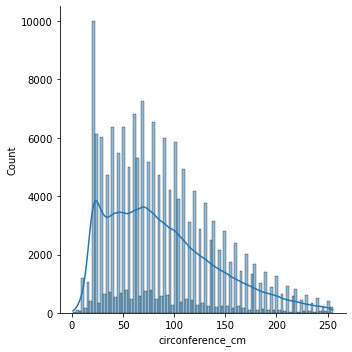

In [17]:
a = data.loc[(data["circonference_cm"] <= 255) & (data["circonference_cm"] > 0)]
sns.displot(data=a, x="circonference_cm", kde=True)

In [18]:
a["circonference_cm"].describe()

count    171801.000000
mean         88.451965
std          52.976410
min           1.000000
25%          45.000000
50%          80.000000
75%         120.000000
max         255.000000
Name: circonference_cm, dtype: float64

In [19]:
a["circonference_cm"].mode()

0    20
dtype: int64

In [20]:
scipy.stats.skew(a["circonference_cm"], axis=0, bias=True, nan_policy='propagate')

0.7695227895406083

In [21]:
scipy.stats.kurtosis(a["circonference_cm"], axis=0, bias=True, nan_policy='propagate')

0.027890140940736163

#### La hauteur

La distribution est irrégulière, mais contient $160122$ arbres après filtrage des données aberrantes. La hauteur maximale est $29 mètres$ et la moyenne est de $10,32 mètres$, tout comme le mode et la médiane. Par contre l'asymétrie est positive, donc vers la droite mais sa valeur est inférieur à $1$, comme l'est aussi son kurtosis. Visuellement, il serait difficile de dire qu'ici s'applique le théorème de limite centrale car nous n'avons pas a première vue une Gaussienne.


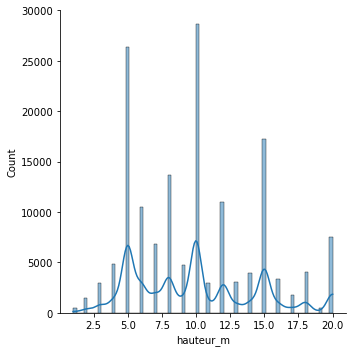

In [22]:
b = data.loc[(data["hauteur_m"] < 21) & (data["hauteur_m"] > 0)]
sns.displot(data=b, x="hauteur_m", kde=True)

In [23]:
b["hauteur_m"].describe()

count    155743.000000
mean          9.928016
std           4.546542
min           1.000000
25%           6.000000
50%          10.000000
75%          13.000000
max          20.000000
Name: hauteur_m, dtype: float64

In [24]:
b["hauteur_m"].mode()

0    10
dtype: int64

In [25]:
scipy.stats.skew(b["hauteur_m"], axis=0, bias=True, nan_policy='propagate')

0.4872105232672621

In [26]:
scipy.stats.kurtosis(b["hauteur_m"], axis=0, bias=True, nan_policy='propagate')

-0.6014377033875058

#### Régression linéaire entre la hauteur et la circonférence

En considérant l'expression de la circonférence d'après la hauteur, nous pouvons constater une corrélation positive entre le données quantitative, autant pour les arbres remarquables, que les premiers. Ainsi nous définissons les données filtrées dans une variable par copy profonde.

In [27]:
data_filtre = data.loc[((data["hauteur_m"] < 21) & (data["hauteur_m"] > 0)) \
                          & ((data["circonference_cm"] < 255) & (data["circonference_cm"] > 0))].copy()
data_filtre.to_excel('data/data_filtre.xlsx')

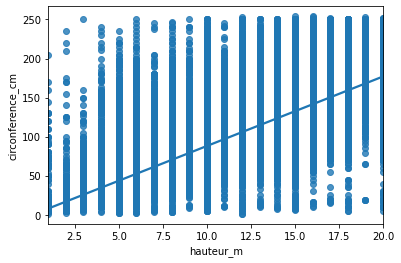

In [28]:
sns.regplot( x="hauteur_m", y="circonference_cm", data=data_filtre);

Si nous ajoutons les variables indépendantes circonférence, hauteur pour les arbres remarquables, nous pourrions sans doute appliquer le théorème de limite centrale sur nos données ainsi filtrés tant les courbes ont une forme dont la régularité s'approche plus d'une gaussienne. Peut-être nous restera-t-il à croiser les données avec d'autres pour affiner la courbe en forme de cloche.

#### Construire une table d'information personnalisée

Il est possible de se passer de la méthode info pour construire un algorithme plus puissant afin d'observer le plus d'information sur les tables :

In [29]:
def informations(data):
    # Header
    print('{:^3}{:<1}{:^20}{:<1}{:^9}{:>1}{:^6}{:<1}{:^15}{:<1}{:^7}{:<1}{:^7}{:<1}'.format('#' , '|' , 'Column', '|', 'Dtype', '|', 'Unique', '|', 'Count Non-Null','|','Mean','|','Std','|'))
    print('{:^3}{:<1}{:^20}{:<1}{:^9}{:>1}{:^6}{:<1}{:^15}{:<1}{:^7}{:<1}{:^7}{:<1}'.format('---' , '|' , '------', '|', '-----', '|', '------', '|', '--------------','|','----','|','---','|'))
    # dtypes information
    dtypes_uniques = set() # Collection of unique elements
    dtypes_listes = [] # list of complete data columns
    memory_usage = 0 # in MB
    for it, col in enumerate(data.columns): # Feed the set and the list
        dtypes_listes.append(str(data[col].dtype))
        if str(data[col].dtype) not in dtypes_uniques:
            dtypes_uniques.add(str(data[col].dtype))
        # Table body
        print('{:^3}{:<1}{:<20}{:<1}{:^9}{:>1}{:<6}{:<1}{:<15}{:<1}{:<7.5}{:<1}{:<7.5}{:<1}'.format(\
                                                str(it), '|' , col, '|',\
                                                str(data[col].dtype), '|', str(len(data[col].unique())),\
                                                '|',str(data[col].count()) + ' Non-null','|',\
                                                str(data[col].mean())\
                                                    if (data[col].dtype in ['int64','float64']) else '','|',\
                                                str(data[col].std())\
                                                    if (data[col].dtype in ['int64','float64']) else '','|'))
        
        # Collect informatives on disk usage by observation onto the data column
        memory_usage += int(data[col].memory_usage(index=True, deep=True))
    # Blend of set and list to print the information line as usual
    dtypes_string = ''
    for x in dtypes_uniques:
        dtypes_string += '{}({}), '.format(x, dtypes_listes.count(x))
    print('\ndtypes: {}'.format(dtypes_string))
    # Digit format to write mem usage in comprehensive format
    print('\nmemory usage: {:.4} MB\n'.format(memory_usage / (1024*1024)))

# 2) Démarche méthodologique d'analyse de données

Nous calculons d'abord quelques détails pour profiler un peu mieux nos données, puis nous créons un rapport au format pdf pour étudier nos données.

Enuite 
À partir de nos jeux de données produites nous calculons les moyennes et les écarts types par la formules de la fonction information() que nous venons de definir dans la cellule au-dessus



In [30]:
informations(data)

 # |       Column       |  Dtype  |Unique|Count Non-Null | Mean  |  Std  |
---|       ------       |  -----  |------|-------------- | ----  |  ---  |
 0 |type_emplacement    | string  |1     |200137 Non-null|       |       |
 1 |domanialite         | string  |9     |200137 Non-null|       |       |
 2 |arrondissement      | string  |25    |200137 Non-null|       |       |
 3 |complement_addresse | string  |3796  |200137 Non-null|       |       |
 4 |numero              | float64 |1     |0 Non-null     |nan    |nan    |
 5 |lieu                | string  |6921  |200137 Non-null|       |       |
 6 |id_emplacement      | string  |69040 |200137 Non-null|       |       |
 7 |libelle_francais    | string  |193   |200137 Non-null|       |       |
 8 |genre               | string  |176   |200137 Non-null|       |       |
 9 |espece              | string  |539   |200137 Non-null|       |       |
10 |variete             | string  |436   |200137 Non-null|       |       |
11 |circonference_cm    |

In [31]:
informations(data_filtre)

 # |       Column       |  Dtype  |Unique|Count Non-Null | Mean  |  Std  |
---|       ------       |  -----  |------|-------------- | ----  |  ---  |
 0 |type_emplacement    | string  |1     |154067 Non-null|       |       |
 1 |domanialite         | string  |9     |154067 Non-null|       |       |
 2 |arrondissement      | string  |25    |154067 Non-null|       |       |
 3 |complement_addresse | string  |3611  |154067 Non-null|       |       |
 4 |numero              | float64 |1     |0 Non-null     |nan    |nan    |
 5 |lieu                | string  |5389  |154067 Non-null|       |       |
 6 |id_emplacement      | string  |46578 |154067 Non-null|       |       |
 7 |libelle_francais    | string  |170   |154067 Non-null|       |       |
 8 |genre               | string  |146   |154067 Non-null|       |       |
 9 |espece              | string  |375   |154067 Non-null|       |       |
10 |variete             | string  |369   |154067 Non-null|       |       |
11 |circonference_cm    |

Maintenant que nous avons nettoyer nos données, nous pouvons regarder à l'intérieur des catégories, pour apprécier l'hétérogénéité des hauteurs, par exemple selon le stade de développement pour le genre Eucalyptus.

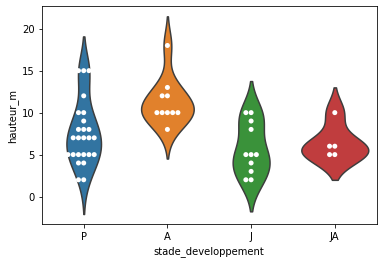

In [32]:
ax = sns.violinplot(x="stade_developpement", y="hauteur_m", data=data_filtre.loc[data_filtre['genre']=='Eucalyptus'], inner=None)

ax = sns.swarmplot(x="stade_developpement", y="hauteur_m", data=data_filtre.loc[data_filtre['genre']=='Eucalyptus'],

                   color="white", edgecolor="gray")

Ou encore voir que les domanialités ont différentes distributions en hauteur pour les platanes.

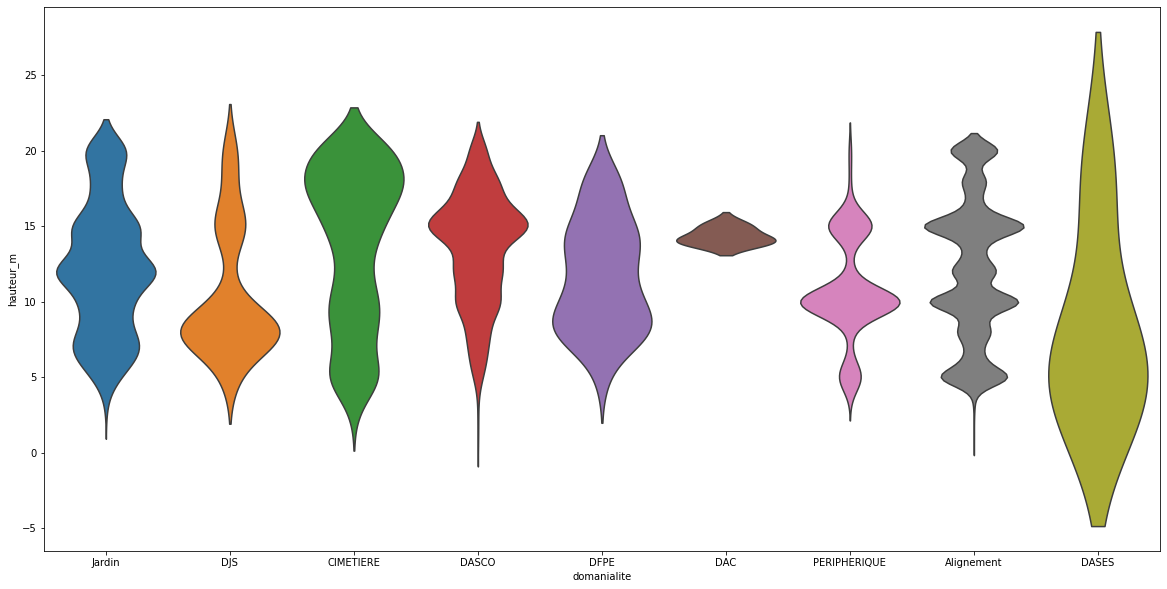

In [33]:
f = plt.figure(figsize=(20 , 10))
ax = sns.violinplot(x="domanialite", y="hauteur_m", data=data_filtre.loc[data_filtre['libelle_francais']=='Platane'], inner=None, scale='width')
plt.show()

Et même que les domanialités ont différentes distributions en stade de développement. Notons que le périphérique
est très orienté sur un seul stade de développement, celui dont les hauteurs et les circonférences sont autant du groupe 'J' que du groupe 'JA'.

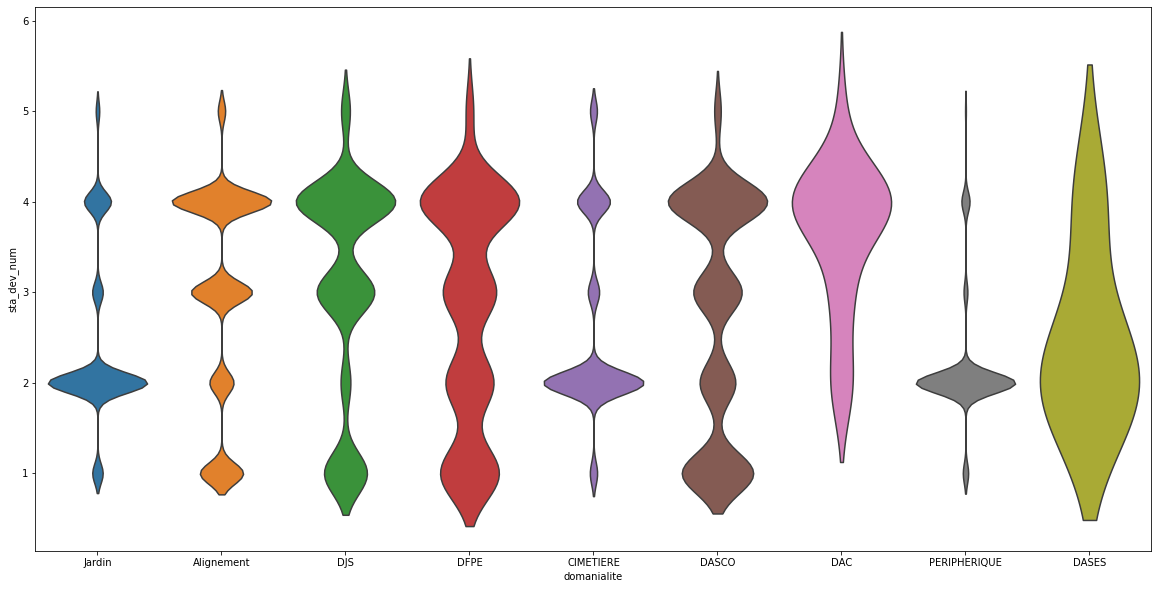

In [34]:
f = plt.figure(figsize=(20 , 10))
ax = sns.violinplot(x="domanialite", y="sta_dev_num", data=data, inner=None, scale='width')
plt.show()

Nous utilisons un filtre sur la base pour éliminer les arbres dont nous ne sommes pas sur de la hauteur ou de la circonférence, puis avec une requête SQL, nous déterminons le nombre d'individu, dans chaque élément quantitatif à l'intérieur de chaque quartier, excepté pour la domanialité qui est une données de catégorie. Nous ajoutons en plus des moyennes ainsi que des pourcentages du nombre d'arbres. Nous commençons notre analyse quantitative sur $159568$ arbres.

In [35]:
q1 = """SELECT  arrondissement,
                ROUND(Count(type_emplacement)* 100. / (Select Count(type_emplacement) From data), 2) as "pourcent",
                count(DISTINCT(domanialite)) as domani,
                count(DISTINCT(lieu)) as lieu,
                count(type_emplacement) as arbres,
                count(DISTINCT(id_emplacement)) as id_empl,
                count(DISTINCT(libelle_francais)) as libel_fr,
                count(DISTINCT(genre)) as genre,
                count(DISTINCT(espece)) as espece,
                count(DISTINCT(variete)) as variete,
                ROUND(AVG(circonference_cm),2) as circon,
                ROUND(AVG(hauteur_m),2) as haut,
                SUM(remarquable) as remarq
                FROM data_filtre GROUP BY data_filtre.arrondissement"""

In [36]:
quant_arr = ps.sqldf(q1, locals())

In [37]:
quant_arr

,arrondissement,pourcent,domani,lieu,arbres,id_empl,libel_fr,genre,espece,variete,circon,haut,remarq
0,BOIS DE BOULOGNE,1.60,2,18,3209,1761,25,21,42,24,77.65,9.63,0
1,BOIS DE VINCENNES,3.64,2,26,7286,4301,94,83,153,41,87.45,10.65,0
2,HAUTS-DE-SEINE,0.44,1,184,890,890,33,28,41,18,69.99,8.97,0
3,PARIS 10E ARRDT,1.45,5,119,2896,1564,59,43,73,64,79.84,10.26,1
4,PARIS 11E ARRDT,2.69,5,176,5393,2353,90,70,107,75,80.61,10.29,0
5,PARIS 12E ARRDT,5.89,9,287,11791,5188,100,80,168,92,80.57,8.92,7
6,PARIS 13E ARRDT,6.67,7,346,13347,5205,114,95,187,120,78.70,9.08,2
7,PARIS 14E ARRDT,5.50,7,330,11008,6018,113,99,179,129,92.82,8.92,2
8,PARIS 15E ARRDT,5.66,8,307,11319,4831,98,81,151,112,80.82,9.28,5
9,PARIS 16E ARRDT,7.18,7,268,14368,5473,120,106,210,131,87.58,10.43,26


Nous faisons la même chose pour chaque domanialité :

In [38]:
q2 = """SELECT  domanialite,
                ROUND(Count(type_emplacement)* 100. / (Select Count(type_emplacement) From data),2) as "pourcent",
                count(DISTINCT(arrondissement)) as arrond,
                count(DISTINCT(stade_developpement)) as devel,
                count(DISTINCT(lieu)) as lieu,
                count(type_emplacement) as arbres,
                count(DISTINCT(id_emplacement)) as id_empl,
                count(DISTINCT(libelle_francais)) as libel_fr,
                count(DISTINCT(genre)) as genre,
                count(DISTINCT(espece)) as espece,
                count(DISTINCT(variete)) as variete,
                ROUND(AVG(circonference_cm),2) as circon,
                ROUND(AVG(hauteur_m),2) as haut,
                SUM(remarquable) as remarq
                FROM data_filtre GROUP BY data_filtre.domanialite"""

In [39]:
quant_dom = ps.sqldf(q2, locals())

In [40]:
quant_dom

,domanialite,pourcent,arrond,devel,lieu,arbres,id_empl,libel_fr,genre,espece,variete,circon,haut,remarq
0,Alignement,48.43,22,5,1793,96920,7555,97,80,167,124,84.85,10.18,4
1,CIMETIERE,7.88,10,5,1876,15775,13306,125,104,175,101,103.04,10.03,6
2,DAC,0.01,5,4,5,21,21,12,10,10,4,116.05,9.38,1
3,DASCO,3.16,20,5,661,6330,6303,96,74,136,159,78.86,8.29,0
4,DASES,0.00,2,2,2,4,4,1,1,1,1,52.50,8.25,0
5,DFPE,0.63,19,5,228,1256,1255,85,67,106,50,79.99,8.30,0
6,DJS,1.81,16,5,103,3630,3619,101,85,152,86,92.48,8.92,0
7,Jardin,12.49,21,5,535,25002,11429,155,134,338,237,87.97,9.48,65
8,PERIPHERIQUE,2.56,9,5,198,5129,5123,62,55,88,28,78.56,8.59,0


Nous observons que le stade de développement peut indiquer une relation avec les produits à utiliser, donc nous utilisons le stade de développement comme pivot.

In [41]:
q3 = """SELECT  stade_developpement,
                ROUND(Count(type_emplacement)* 100. / (Select Count(type_emplacement) From data),2) as "pourcent",
                count(DISTINCT(arrondissement)) as arrond,
                count(DISTINCT(domanialite)) as domani,
                count(DISTINCT(lieu)) as lieu,
                count(type_emplacement) as arbres,
                count(DISTINCT(id_emplacement)) as id_empl,
                count(DISTINCT(libelle_francais)) as libel_fr,
                count(DISTINCT(genre)) as genre,
                count(DISTINCT(espece)) as espece,
                count(DISTINCT(variete)) as variete,
                ROUND(AVG(circonference_cm), 2) as circon,
                ROUND(AVG(hauteur_m), 2) as haut,
                SUM(remarquable) as remarq
                FROM data_filtre GROUP BY data_filtre.stade_developpement"""

In [42]:
quant_dev = ps.sqldf(q3, locals())

In [43]:
quant_dev

,stade_developpement,pourcent,arrond,domani,lieu,arbres,id_empl,libel_fr,genre,espece,variete,circon,haut,remarq
0,A,30.17,25,9,3415,60381,19108,132,114,241,140,118.55,12.65,41
1,J,13.18,25,7,2614,26383,10124,132,112,266,255,38.76,5.76,1
2,JA,17.21,25,8,2755,34443,10613,132,109,228,146,70.59,9.02,1
3,M,1.84,25,8,865,3673,2438,69,60,97,29,191.48,16.45,31
4,P,14.58,25,9,2623,29187,17284,151,129,281,258,71.06,8.03,2


Ici nous exprimons les quantités par stade de développement, et par domanialité

In [44]:
q4 = """SELECT  stade_developpement as devel,
                domanialite as domani,
                ROUND(Count(type_emplacement)* 100. / (Select Count(type_emplacement) From data), 2) as "pourcent",
                count(DISTINCT(arrondissement)) as arrond,
                count(DISTINCT(lieu)) as lieu,
                count(type_emplacement) as arbres,
                count(DISTINCT(id_emplacement)) as id_empl,
                count(DISTINCT(libelle_francais)) as libel_fr,
                count(DISTINCT(genre)) as genre,
                count(DISTINCT(espece)) as espece,
                count(DISTINCT(variete)) as variete,
                ROUND(AVG(circonference_cm),2) as circon,
                ROUND(AVG(hauteur_m),2) as haut,
                SUM(remarquable) as remarq
                FROM data_filtre GROUP BY data_filtre.stade_developpement, domanialite
                ORDER BY devel, domani, haut"""

In [45]:
quant_dev_dom = ps.sqldf(q4, locals())

In [46]:
quant_dev_dom

,devel,domani,pourcent,arrond,lieu,arbres,id_empl,libel_fr,genre,espece,variete,circon,haut,remarq
0,A,Alignement,21.42,22,1374,42863,4855,71,59,112,77,115.42,12.83,2
1,A,CIMETIERE,2.94,9,962,5891,5408,81,71,96,39,137.65,12.96,5
2,A,DAC,0.01,3,3,14,14,7,7,6,3,135.50,11.86,0
3,A,DASCO,1.21,20,524,2419,2416,64,48,71,25,124.68,11.87,0
4,A,DASES,0.00,1,1,1,1,1,1,1,1,150.00,18.00,0
5,A,DFPE,0.24,16,131,486,486,47,38,57,19,115.47,10.77,0
6,A,DJS,0.88,15,91,1765,1763,55,47,76,25,126.12,11.11,0
7,A,Jardin,3.29,21,285,6576,4575,115,101,207,94,117.35,12.05,34
8,A,PERIPHERIQUE,0.18,8,50,366,366,29,25,35,7,124.90,12.09,0
9,J,Alignement,9.52,22,1151,19046,4018,81,65,129,89,40.33,6.06,0


In [47]:
q5 = """SELECT  genre,
                ROUND(Count(type_emplacement)* 100. / (Select Count(type_emplacement) From data),2) as "pourcent",
                count(DISTINCT(arrondissement)) as arrond,
                count(DISTINCT(domanialite)) as domani,
                count(DISTINCT(lieu)) as lieu,
                count(type_emplacement) as arbres,
                count(DISTINCT(id_emplacement)) as id_empl,
                count(DISTINCT(libelle_francais)) as libel_fr,
                count(DISTINCT(variete)) as variete,
                count(DISTINCT(espece)) as espece,
                ROUND(AVG(sta_dev_num), 2) as cat_age,
                ROUND(AVG(circonference_cm), 2) as circon,
                ROUND(AVG(hauteur_m), 2) as haut,
                SUM(remarquable) as remarq
                FROM data GROUP BY data.genre"""

In [48]:
quant_gen = ps.sqldf(q5, locals())

In [49]:
quant_gen.to_excel('quant_gen.xlsx')

In [50]:
q5 = """SELECT  genre,
                ROUND(Count(type_emplacement)* 100. / (Select Count(type_emplacement) From data),2) as "pourcent",
                count(DISTINCT(arrondissement)) as arrond,
                count(DISTINCT(domanialite)) as domani,
                count(DISTINCT(lieu)) as lieu,
                count(type_emplacement) as arbres,
                count(DISTINCT(id_emplacement)) as id_empl,
                count(DISTINCT(libelle_francais)) as libel_fr,
                count(DISTINCT(variete)) as variete,
                count(DISTINCT(espece)) as espece,
                ROUND(AVG(sta_dev_num), 2) as cat_age,
                ROUND(AVG(circonference_cm), 2) as circon,
                ROUND(AVG(hauteur_m), 2) as haut,
                SUM(remarquable) as remarq
                FROM data_filtre GROUP BY data_filtre.genre"""

In [51]:
quant_gen_filtre = ps.sqldf(q5, locals())

In [52]:
quant_gen_filtre.to_excel('quant_gen_filtre.xlsx')

In [53]:
quant_gen_filtre

,genre,pourcent,arrond,domani,lieu,arbres,id_empl,libel_fr,variete,espece,cat_age,circon,haut,remarq
0,Abelia,0.00,2,2,2,2,2,1,1,2,3.00,47.50,5.50,0.0
1,Abies,0.03,15,4,26,70,70,1,1,8,2.33,65.09,8.13,0.0
2,Acacia,0.00,2,2,2,6,6,1,2,1,2.00,24.17,5.00,0.0
3,Acca,0.00,1,1,2,2,2,2,2,1,1.50,10.00,1.00,0.0
4,Acer,6.15,25,8,1377,12311,8240,2,47,36,2.89,88.27,9.92,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,Viburnum,0.00,2,1,3,3,3,1,1,1,1.67,30.00,5.00,0.0
142,Zanthoxylum,0.01,7,3,8,11,11,1,1,2,2.73,36.82,4.64,0.0
143,Zelkova,0.13,19,7,52,253,247,2,5,5,2.01,55.66,6.75,0.0
144,x Chitalpa,0.01,8,6,13,16,16,2,2,2,1.50,23.44,3.44,0.0


Ici nous normalisons nos données pour pouvoir les comparer dans un graphique en les ordonnant

In [54]:
x = quant_gen[['haut','circon','cat_age','arbres']].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns=['haut','circon','cat_age','arbres'])
df['genre'] = quant_gen['genre']
df

,haut,circon,cat_age,arbres,genre
0,0.109715,0.293790,0.666667,0.000023,Abelia
1,0.098743,0.262803,0.410000,0.002794,Abies
2,0.066427,0.226806,0.333333,0.000188,Acacia
3,0.019948,0.061851,0.166667,0.000023,Acca
4,0.140634,0.431779,0.543333,0.433670,Acer
...,...,...,...,...,...
171,0.000000,0.142256,0.333333,0.000000,Ziziphus
172,0.000000,0.000000,0.333333,0.000352,n. sp.
173,0.064632,0.136442,0.176667,0.000376,x Chitalpa
174,0.118891,0.319211,0.326667,0.015943,x Cupressocyparis


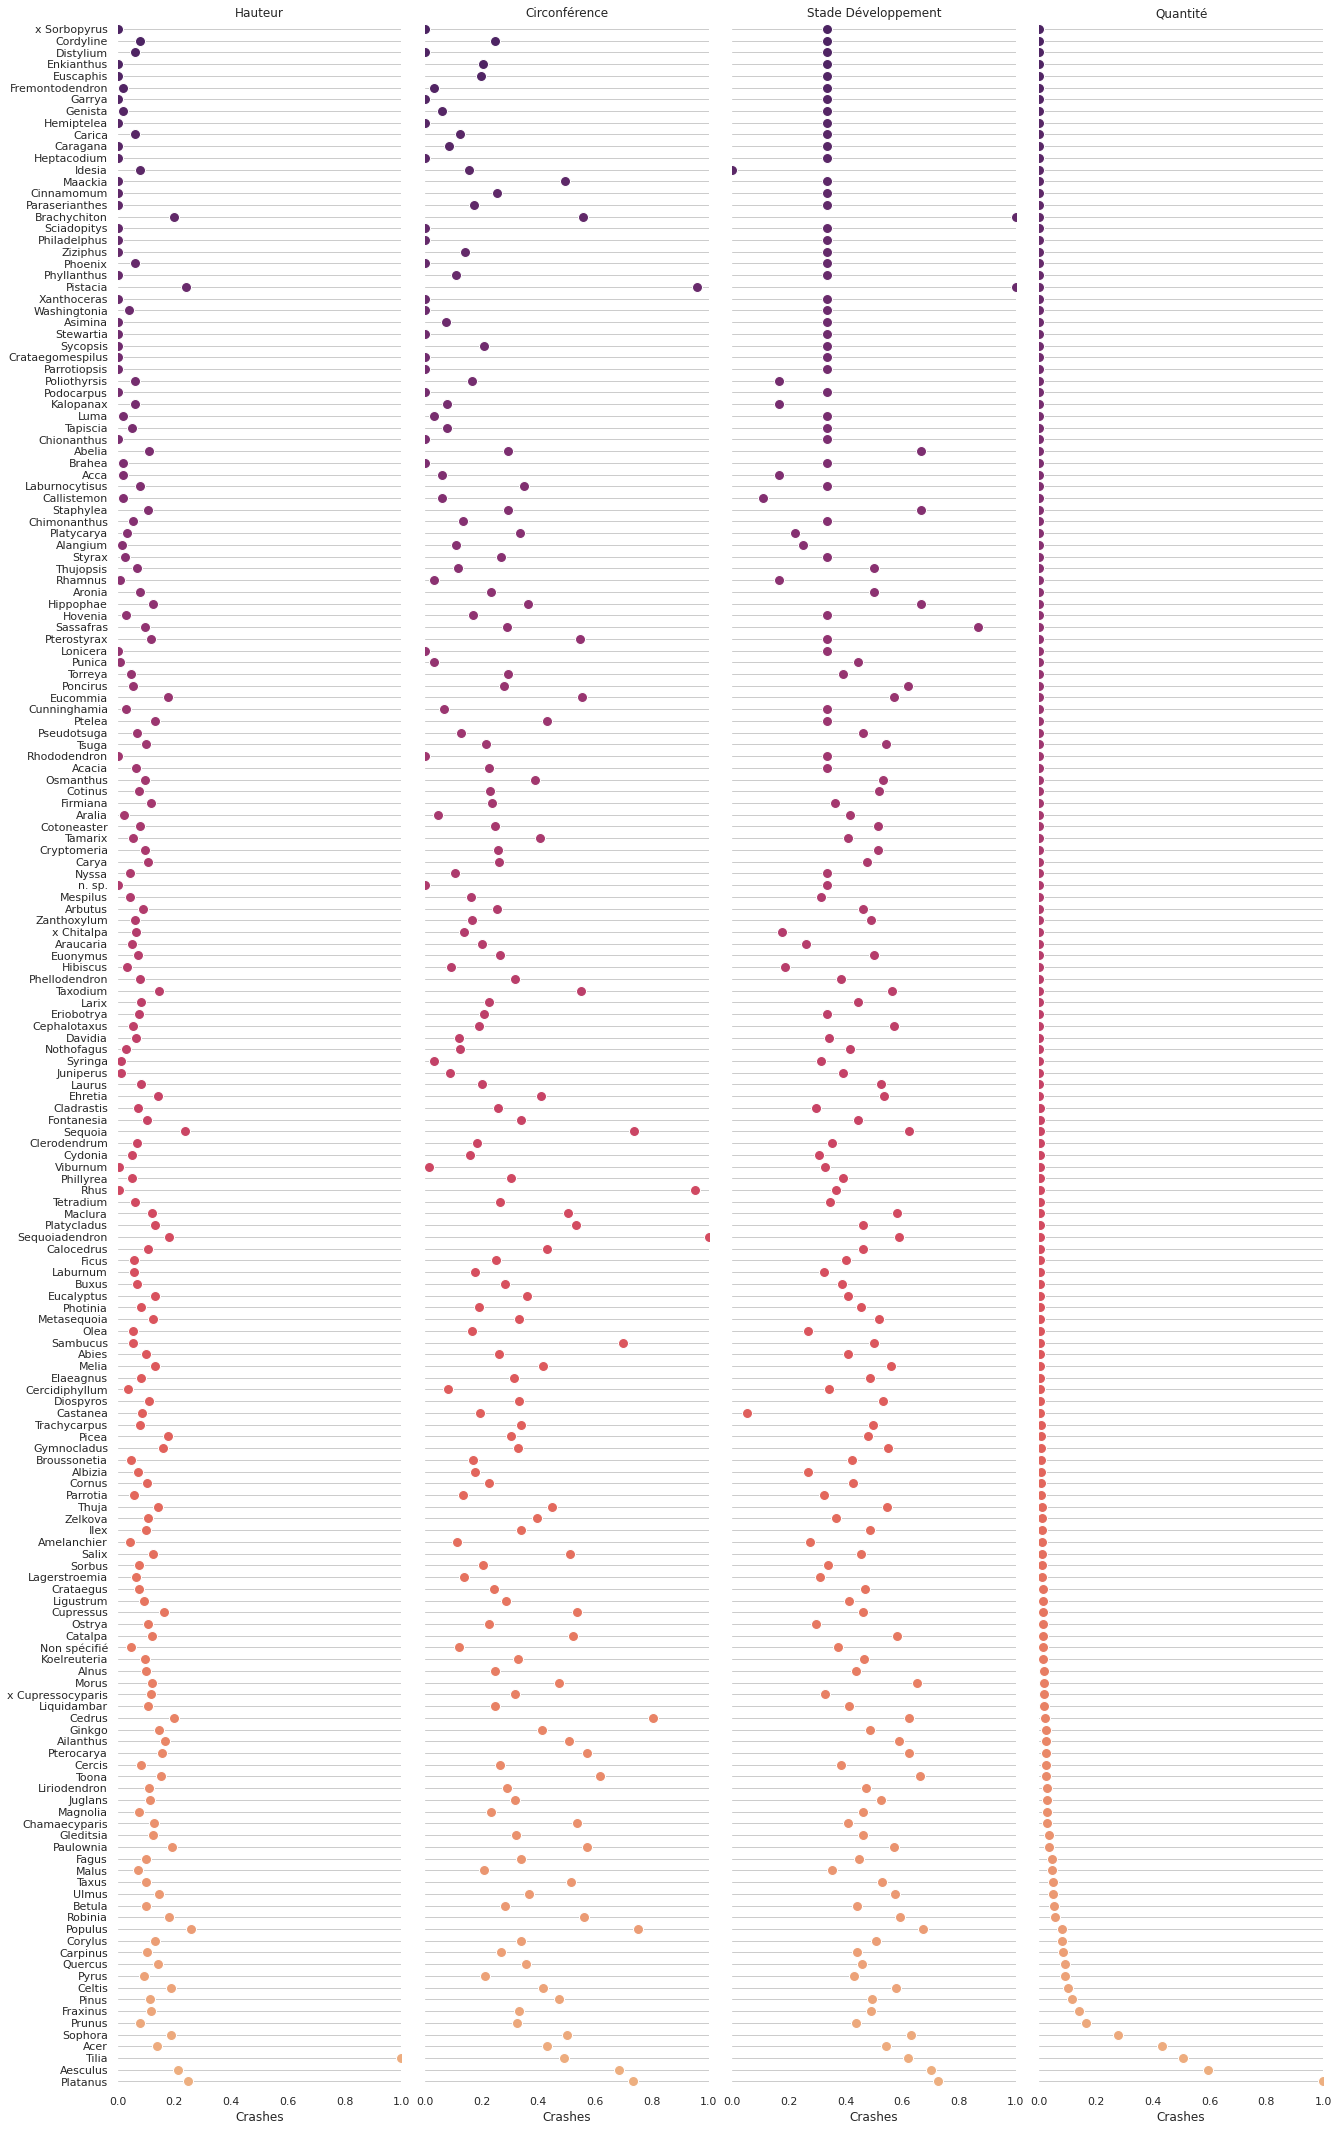

In [55]:
sns.set_theme(style="whitegrid")

# Load the dataset
crashes = df

# Make the PairGrid
g = sns.PairGrid(crashes.sort_values("arbres", ascending=True),
                 x_vars=crashes.columns[:4], y_vars=["genre"],
                 height=30, aspect=.15)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, 1), xlabel="Crashes", ylabel="")

# Use semantically meaningful titles for the columns
titles = ["Hauteur", "Circonférence", "Stade Développement",
          "Quantité"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

<AxesSubplot:xlabel='haut', ylabel='circon'>

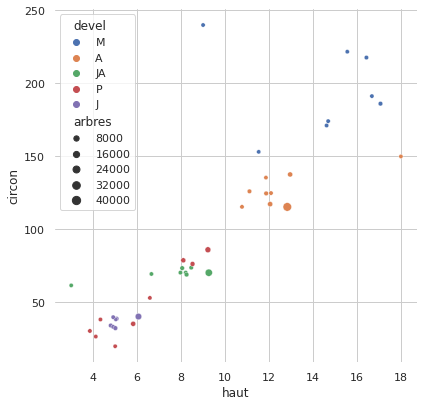

In [56]:
sns.set_theme(style="whitegrid")

df = quant_dev_dom[['haut','circon', 'arbres', 'devel']]

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
clarity_ranking = ['M','A','JA','P','J']
sns.scatterplot(x="haut", y="circon",
                hue="devel", hue_order=clarity_ranking,
                size="arbres",
                data=df, ci="sd",ax=ax)

<AxesSubplot:xlabel='circon', ylabel='haut'>

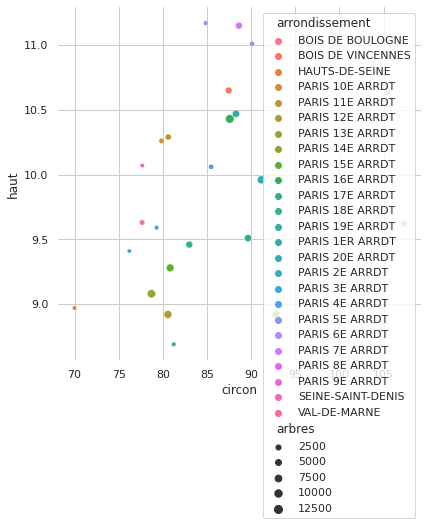

In [57]:
sns.set_theme(style="whitegrid")

df = quant_arr[['haut','circon', 'arbres', 'arrondissement']]

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
#clarity_ranking = ['M','A','JA','P','J']
sns.scatterplot(x="circon", y="haut",
                hue="arrondissement", #hue_order=clarity_ranking,
                size="arbres",
                data=df, ci="sd",ax=ax)

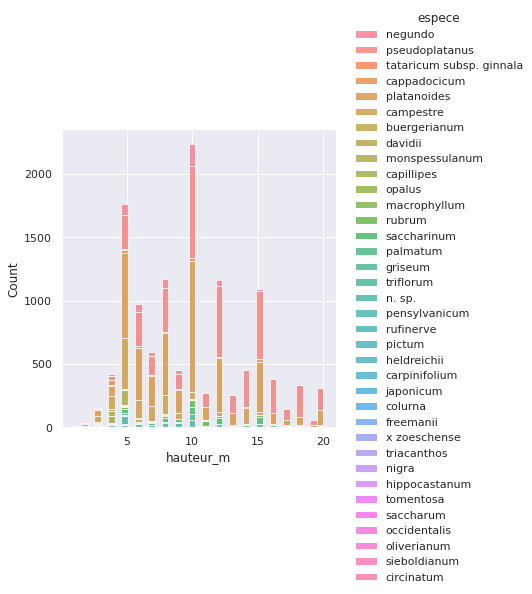

In [58]:
sns.set()
sns_plot = sns.displot(data_filtre.loc[data_filtre['genre'] == 'Acer'], x="hauteur_m", hue="espece", multiple="stack")
sns_plot.savefig("output.png")

/home/romain/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/romain/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='circonference_cm', ylabel='Density'>

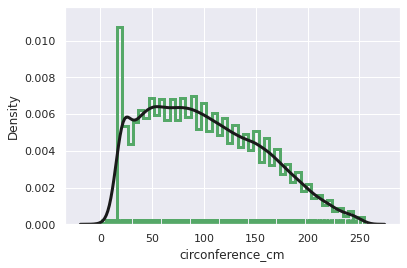

In [59]:
sns.distplot(data_filtre['circonference_cm'].loc[data['genre'] == 'Platanus'], rug=True, 
                                 rug_kws={"color": "g"},
                                kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                                hist_kws={"histtype": "step", "linewidth": 3,
                                 "alpha": 1, "color": "g"})

In [60]:
quant = pd.DataFrame(sklearn.preprocessing.normalize(quant_gen_filtre[['arbres','cat_age','haut', 'circon']]),
                     columns=['arbres','cat_age','haut', 'circon'])
quant['genre'] = quant_gen_filtre['genre']
quant

,arbres,cat_age,haut,circon,genre
0,0.041707,0.062561,0.114695,0.990551,Abelia
1,0.729474,0.024281,0.084723,0.678307,Abies
2,0.235486,0.078495,0.196239,0.948617,Acacia
3,0.193122,0.144841,0.096561,0.965609,Acca
4,0.999974,0.000235,0.000806,0.007170,Acer
...,...,...,...,...,...
141,0.098017,0.054563,0.163361,0.980168,Viburnum
142,0.283481,0.070355,0.119578,0.948889,Zanthoxylum
143,0.976284,0.007756,0.026047,0.214782,Zelkova
144,0.558909,0.052398,0.120165,0.818801,x Chitalpa


<AxesSubplot:xlabel='haut', ylabel='circon'>

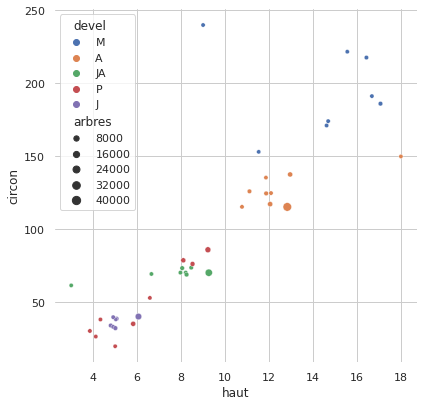

In [61]:
sns.set_theme(style="whitegrid")

df = quant_dev_dom[['haut','circon', 'arbres', 'devel']]

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
clarity_ranking = ['M','A','JA','P','J']
sns.scatterplot(x="haut", y="circon",
                hue="devel", hue_order=clarity_ranking,
                size="arbres",
                data=df, ci="sd",ax=ax)

<AxesSubplot:xlabel='circon', ylabel='haut'>

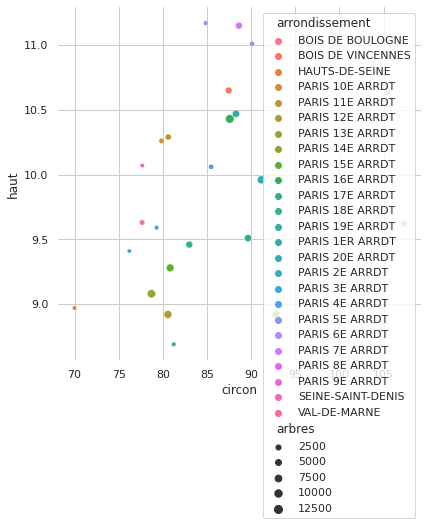

In [62]:
sns.set_theme(style="whitegrid")

df = quant_arr[['haut','circon', 'arbres', 'arrondissement']]

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
#clarity_ranking = ['M','A','JA','P','J']
sns.scatterplot(x="circon", y="haut",
                hue="arrondissement", #hue_order=clarity_ranking,
                size="arbres",
                data=df, ci="sd",ax=ax)

<AxesSubplot:xlabel='circon', ylabel='haut'>

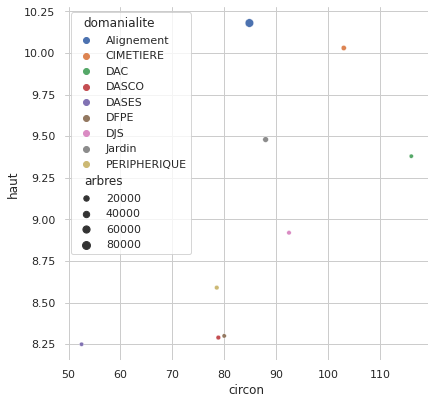

In [63]:
sns.set_theme(style="whitegrid")

df = quant_dom[['haut','circon', 'arbres', 'domanialite']]

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
#clarity_ranking = ['M','A','JA','P','J']
sns.scatterplot(x="circon", y="haut",
                hue="domanialite", #hue_order=clarity_ranking,
                size="arbres",
                data=df, ci="sd",ax=ax)

## Nous calculons les moyennes et les quantiles sup et inf pour les hauteurs et les circonférences

Nous travaillons comme suit à partir des données filtrées en choisissant un panel de quantiles de bornes superieures et inférieures [[0.8, 0.2],[0.85,0.15],[0.90,0.10],[0.95, 0.05], [0.98,0.02],[0.99,0.01]] et nous les entrons en paramètre dans l'algorithme suivant pour obtenir à chaque tour, 7 nouvelles tables avec des données qui nous permettront de faire 11 graphiques, et d'indiquer quels arbres sont en faiblesse ou en sur-dimension dans notre intervalle de confiance selon les hauteurs, et selon les circonférences.

![Analyse Univariée](analyse.png)

In [82]:
"""
q_h = 0.85
q_b = 0.15
mean = pd.DataFrame()
std = pd.DataFrame()
data_filtre_moy_qut = pd.DataFrame()
for arr in list(data_filtre['libelle_francais'].unique()):
    for age in list(data_filtre['stade_developpement'].unique()):
        mean = data_filtre.loc[(data_filtre['libelle_francais'] == arr) & (data_filtre['stade_developpement'] == age)].mean()
        std = data_filtre.loc[(data_filtre['libelle_francais'] == arr) & (data_filtre['stade_developpement'] == age)].std()  
        qut_h = data_filtre.loc[(data_filtre['libelle_francais'] == arr) & (data_filtre['stade_developpement'] == age)].quantile(q=q_h)  
        qut_b = data_filtre.loc[(data_filtre['libelle_francais'] == arr) & (data_filtre['stade_developpement'] == age)].quantile(q=q_b)  
        data_filtre_moy_qut = data_filtre_moy_qut.append({'libel':arr, 'age':age, 'quantite_var_par_age': 
                        int(data_filtre['type_emplacement'].loc[(data_filtre['libelle_francais'] == arr) &
                                                                (data_filtre['stade_developpement'] == age)].count()),                    
                        'avg_h': mean['hauteur_m'], 'std_h': std['hauteur_m'], 'qut_h_h':qut_h['hauteur_m'],'qut_h_b':qut_b['hauteur_m'],
                       'avg_c': mean['circonference_cm'], 'std_c': std['circonference_cm'], 'qut_c_h': qut_h['circonference_cm'], 'qut_c_b': qut_b['circonference_cm']}, 
                       ignore_index=True)
"""

Nous récupérons cela dans une dataframe que nous nommons data_filtre_moy_qut

In [83]:
"""
data_filtre_moy_qut = data_filtre_moy_qut.convert_dtypes()
data_filtre_moy_qut['quantite_var_par_age'] = data_filtre_moy_qut['quantite_var_par_age'].astype('int32', copy=False)
data_filtre_moy_qut.info()
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   850 non-null    string 
 1   avg_c                 616 non-null    float64
 2   avg_h                 616 non-null    float64
 3   libel                 850 non-null    string 
 4   quantite_var_par_age  850 non-null    int32  
 5   qut_c_b               616 non-null    float64
 6   qut_c_h               616 non-null    float64
 7   qut_h_b               616 non-null    float64
 8   qut_h_h               616 non-null    float64
 9   std_c                 526 non-null    float64
 10  std_h                 526 non-null    float64
dtypes: float64(8), int32(1), string(2)
memory usage: 69.9 KB


In [84]:
"""
data_filtre_moy_qut[['libel','age','quantite_var_par_age','avg_h','std_h', 'qut_h_h', 'qut_h_b','avg_c','std_c', 'qut_c_h', 'qut_c_b']].sort_values(by=['libel','age']).reset_index()
"""

,index,libel,age,quantite_var_par_age,avg_h,std_h,qut_h_h,qut_h_b,avg_c,std_c,qut_c_h,qut_c_b
0,486,Abelia,A,1,6.000000,NaN,6.0,6.00,75.000000,NaN,75.0,75.0
1,487,Abelia,J,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,489,Abelia,JA,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,488,Abelia,M,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,485,Abelia,P,1,5.000000,NaN,5.0,5.00,20.000000,NaN,20.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...
845,141,n. sp.,A,394,10.824873,4.203753,15.0,7.00,95.809645,40.205475,140.0,53.0
846,142,n. sp.,J,331,4.779456,1.789617,6.0,3.00,30.942598,15.415450,45.0,19.0
847,144,n. sp.,JA,394,8.030457,3.100371,12.0,5.00,69.964467,31.666017,110.0,35.0
848,143,n. sp.,M,6,14.166667,5.845226,20.0,8.75,140.333333,45.262199,175.0,94.0


In [167]:
data_filtre_moy_qut = pd.read_excel('data/data_filtre_moy_qut_0.95_0.05.xlsx')

In [85]:
q8 = """SELECT  data_filtre_moy_qut.libel as libelle_francais,
                    data_filtre_moy_qut.age,
                    data_filtre_moy_qut.quantite_var_par_age,
                    data_filtre_moy_qut.avg_h,
                    data_filtre_moy_qut.qut_h_h,
                    data_filtre_moy_qut.qut_h_b,
                    data_filtre_moy_qut.std_h,
                    data_filtre_moy_qut.avg_c,
                    data_filtre_moy_qut.qut_c_h,
                    data_filtre_moy_qut.qut_c_b,
                    data_filtre_moy_qut.std_c,
                    data_filtre.type_emplacement,
                    data_filtre.domanialite,
                    data_filtre.arrondissement,
                    data_filtre.complement_addresse,
                    data_filtre.lieu,
                    data_filtre.id_emplacement,
                    data_filtre.genre,
                    data_filtre.espece,
                    data_filtre.variete,
                    data_filtre.hauteur_m,
                    data_filtre.stade_developpement,
                    data_filtre.circonference_cm,
                    data_filtre.remarquable,
                    data_filtre.sta_dev_num,
                    data_filtre.geo_point_2d_a as lat,
                    data_filtre.geo_point_2d_b as lon
                FROM data_filtre 
                JOIN data_filtre_moy_qut 
                ON data_filtre_moy_qut.libel = data_filtre.libelle_francais 
                AND data_filtre.stade_developpement = data_filtre_moy_qut.age """

In [86]:
actions = ps.sqldf(q8, locals())

In [87]:
actions.libelle_francais.loc[actions['libelle_francais'] == 'Marronnier'].count()

21602

## Dépose d'un marqueur de soin concernant la santé de l'arbre.

In [88]:
actions['sante'] = ''
actions['soin'] = ''

In [89]:
#load = actions.copy()

Le code ci-dessous est long à calculer

In [90]:
"""
for lib in list(load.libelle_francais.unique()):
    load.loc[actions['libelle_francais'] == lib, 'nb_arbre_meme_libel'] = load.libelle_francais.loc[actions['libelle_francais'] == lib].count()
for arr in list(load.arrondissement.unique()):
    load.loc[actions['arrondissement'] == arr, 'nb_arbre_meme_arr'] = load.arrondissement.loc[actions['arrondissement'] == arr].count()
for arr in list(load.arrondissement.unique()):
    for soin in ['à surveiller']:
        load.loc[actions['arrondissement'] == arr, 'nb_surv_arr'] = load.arrondissement.loc[(actions['arrondissement'] == arr) & (actions['soin'] == soin)].count()
for lieu in list(load.lieu.unique()):
    for soin in ['à surveiller']:
        load.loc[actions['lieu'] == lieu, 'nb_surv_lieu'] = load.lieu.loc[(actions['lieu'] == lieu) & (actions['soin'] == soin)].count()
"""        

In [91]:
#load['nb_arbre_meme_libel'].sort_values()

13424         1.0
7649          1.0
28788         1.0
138812        1.0
12098         1.0
           ...   
96380     35968.0
124335    35968.0
124336    35968.0
124317    35968.0
64919     35968.0
Name: nb_arbre_meme_libel, Length: 154067, dtype: float64

In [92]:
#load['nb_arbre_meme_arr'].sort_values()

113833      527.0
73668       527.0
73722       527.0
73723       527.0
73724       527.0
           ...   
85345     14368.0
85346     14368.0
85347     14368.0
85335     14368.0
53230     14368.0
Name: nb_arbre_meme_arr, Length: 154067, dtype: float64

In [93]:
"""
load.loc[(load['hauteur_m'] <= load['qut_h_b'])|(load['circonference_cm'] <= load['qut_c_b']), 'sante'] = 'au-dessous'
load.loc[(load['hauteur_m'] <= load['qut_h_b'])|(load['circonference_cm'] <= load['qut_c_b']), 'soin'] = 'à surveiller'
load.loc[(load['hauteur_m'] <= load['qut_h_b'])|(load['circonference_cm'] <= load['qut_c_b']), 'value_moy_c'] = load['qut_c_b'].loc[(load['hauteur_m'] <= load['qut_h_b'])&(load['circonference_cm'] <= load['qut_c_b'])]
load.loc[(load['hauteur_m'] <= load['qut_h_b'])|(load['circonference_cm'] <= load['qut_c_b']), 'value_moy_h'] = load['qut_h_b'].loc[(load['hauteur_m'] <= load['qut_h_b'])&(load['circonference_cm'] <= load['qut_c_b'])]
"""

In [94]:
"""
load.loc[(load['hauteur_m'] >= load['qut_h_h'])|(load['circonference_cm'] >= load['qut_c_h']), 'sante'] = 'au-dessus'
load.loc[(load['hauteur_m'] >= load['qut_h_h'])|(load['circonference_cm'] >= load['qut_c_h']), 'soin'] = 'à surveiller'
load.loc[(load['hauteur_m'] >= load['qut_h_h'])|(load['circonference_cm'] >= load['qut_c_h']), 'value_moy_c'] = load['qut_c_h'].loc[(load['hauteur_m'] >= load['qut_h_h'])&(load['circonference_cm'] >= load['qut_c_h'])]
load.loc[(load['hauteur_m'] >= load['qut_h_h'])|(load['circonference_cm'] >= load['qut_c_h']), 'value_moy_h'] = load['qut_h_h'].loc[(load['hauteur_m'] >= load['qut_h_h'])&(load['circonference_cm'] >= load['qut_c_h'])]
load['sante'].value_counts()
"""

              53749
au-dessous    51173
au-dessus     49145
Name: sante, dtype: int64

In [95]:
"""
load.loc[((load['hauteur_m'] < load['qut_h_h'])&(load['circonference_cm'] < load['qut_c_h']))
         &((load['hauteur_m'] > load['qut_h_b'])&(load['circonference_cm'] > load['qut_c_b'])), 'sante'] = 'norm'
load.loc[((load['hauteur_m'] < load['qut_h_h'])&(load['circonference_cm'] < load['qut_c_h']))
         &((load['hauteur_m'] > load['qut_h_b'])&(load['circonference_cm'] > load['qut_c_b'])), 'soin'] = 'normal'
load.loc[((load['hauteur_m'] < load['qut_h_h'])&(load['circonference_cm'] < load['qut_c_h']))
         &((load['hauteur_m'] > load['qut_h_b'])&(load['circonference_cm'] > load['qut_c_b'])), 'value_moy_c'] = load['avg_c'].loc[((load['hauteur_m'] < load['qut_h_h'])|(load['circonference_cm'] < load['qut_c_h']))]
load.loc[((load['hauteur_m'] < load['qut_h_h'])&(load['circonference_cm'] < load['qut_c_h']))
         &((load['hauteur_m'] > load['qut_h_b'])&(load['circonference_cm'] > load['qut_c_b'])), 'value_moy_h'] = load['avg_h'].loc[((load['hauteur_m'] < load['qut_h_h'])|(load['circonference_cm'] < load['qut_c_h']))]
"""

In [96]:
#actions = load.copy()

In [97]:
actions = pd.read_excel('data/actions_0.95_0.05.xlsx') # Fichier déjà calculé

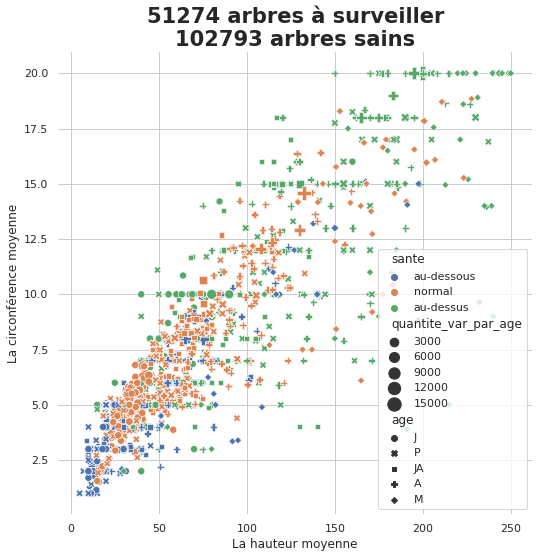

In [98]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(8.5, 8.5))
sns.despine(f, left=True, bottom=True)
plt.title(str(actions['libelle_francais'].loc[actions['soin']=='à surveiller'].count()) + ' arbres à surveiller\n' 
          +str(actions['libelle_francais'].loc[actions['soin']=='normal'].count()) + ' arbres sains',
          fontdict={'fontsize':21, 'fontweight': 'bold'})
plt.ylabel('La circonférence moyenne')
plt.xlabel('La hauteur moyenne')

sns.scatterplot(x="value_moy_c", y='value_moy_h',
                hue="sante", style_order=['J','P','JA','A','M'],
                size='quantite_var_par_age',sizes=(50, 200),
                style='age', size_order=(actions['nb_arbre_meme_libel'].min(),actions['nb_arbre_meme_libel'].min()),
                data=actions[['value_moy_h','arrondissement','value_moy_c','age','sante','soin','quantite_var_par_age']], ci="sd",ax=ax)

plt.show()

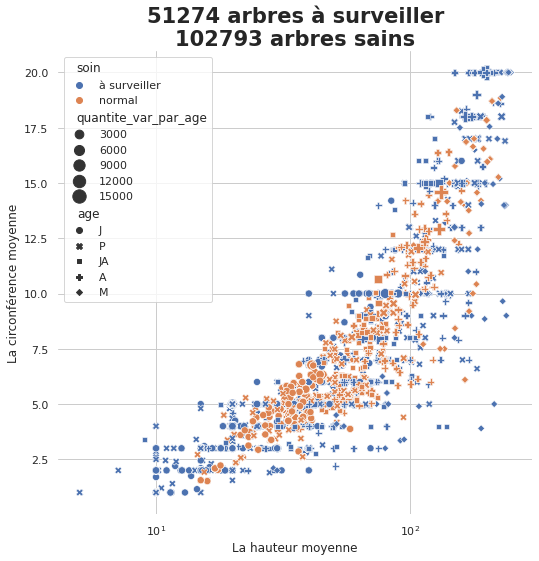

In [99]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(8.5, 8.5))
sns.despine(f, left=True, bottom=True)
plt.title(str(actions['libelle_francais'].loc[actions['soin']=='à surveiller'].count()) + ' arbres à surveiller\n' 
          +str(actions['libelle_francais'].loc[actions['soin']=='normal'].count()) + ' arbres sains',
          fontdict={'fontsize':21, 'fontweight': 'bold'})
plt.ylabel('La circonférence moyenne')
plt.xlabel('La hauteur moyenne')
plt.xscale('Symlog')
plt.yscale('Linear')

sns.scatterplot(x="value_moy_c", y='value_moy_h',
                hue="soin", style_order=['J','P','JA','A','M'],
                size='quantite_var_par_age',sizes=(50, 200),
                style='age', size_order=(actions['nb_arbre_meme_libel'].min(),actions['nb_arbre_meme_libel'].min()),
                data=actions[['value_moy_h','arrondissement','value_moy_c','age','sante','soin','quantite_var_par_age']], ci="sd",ax=ax)

plt.show()

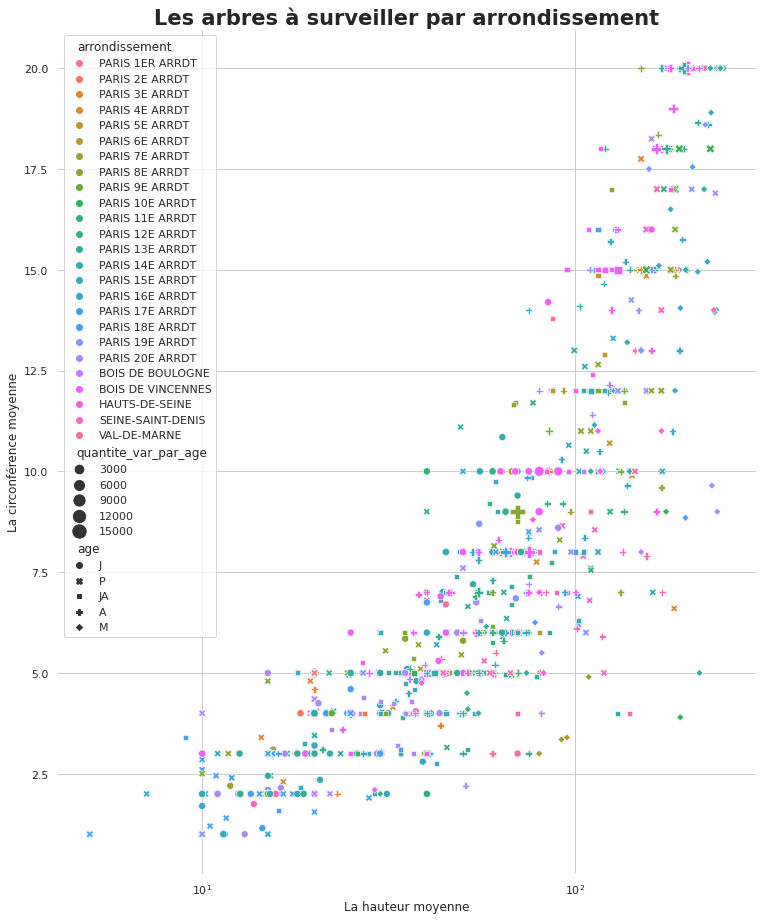

In [100]:
sns.set_theme(style="whitegrid")

arr_list = [

 'PARIS 1ER ARRDT',
 'PARIS 2E ARRDT',
 'PARIS 3E ARRDT',
 'PARIS 4E ARRDT',
 'PARIS 5E ARRDT',
 'PARIS 6E ARRDT',
 'PARIS 7E ARRDT',
 'PARIS 8E ARRDT',
 'PARIS 9E ARRDT',
 'PARIS 10E ARRDT',
 'PARIS 11E ARRDT',
 'PARIS 12E ARRDT',
 'PARIS 13E ARRDT',
 'PARIS 14E ARRDT',
 'PARIS 15E ARRDT',
 'PARIS 16E ARRDT',
 'PARIS 17E ARRDT',
 'PARIS 18E ARRDT',
 'PARIS 19E ARRDT',
 'PARIS 20E ARRDT',
 'BOIS DE BOULOGNE',
 'BOIS DE VINCENNES',
 'HAUTS-DE-SEINE',
 'SEINE-SAINT-DENIS',
 'VAL-DE-MARNE']

f, ax = plt.subplots(figsize=(12.5, 15.5))
sns.despine(f, left=True, bottom=True)
plt.title('Les arbres à surveiller par arrondissement',
          fontdict={'fontsize':21, 'fontweight': 'bold'})
plt.ylabel('La circonférence moyenne')
plt.xlabel('La hauteur moyenne')
plt.xscale('Symlog')
plt.yscale('Linear')#clarity_ranking = ['M','A','JA','P','J']
sns.scatterplot(x="value_moy_c", y='value_moy_h',
                hue_order=arr_list,
                hue="arrondissement", style_order=['J','P','JA','A','M'],
                size='quantite_var_par_age',sizes=(50, 200),
                style='age',
                 size_order=(actions['nb_arbre_meme_libel'].min(),actions['nb_arbre_meme_libel'].min()),
                data=actions[['value_moy_h','arrondissement','value_moy_c','age','sante','soin','quantite_var_par_age']].loc[actions['soin']=='à surveiller'], ci='sd',ax=ax)
plt.show()

### Analyse du nombre d'arbre par arrondissement.

Nous réalisons des jointures complexes de tables pour aggréger des données relatives aux lieux, aux arrondissements picspicsainsi qu'aux quantités d'arbres.

In [101]:
data_end = pd.read_excel('data/new_data_end_0.95_0.05.xlsx') # Nous avons calculer cette table au préalable

In [102]:
q9 = """SELECT data_end.arrondissement as arr, 
                COUNT(*) as total
                FROM data_end
               GROUP BY data_end.arrondissement
"""

In [103]:
actions_hist = ps.sqldf(q9, locals())

In [105]:
q10 = """SELECT data_end.arrondissement as arr, 
                COUNT(soin) as surveiller
                FROM data_end WHERE soin LIKE '%surveiller'
               GROUP BY data_end.arrondissement
"""

In [106]:
actions_hist_soin = ps.sqldf(q10, locals())

In [108]:
qa10 = """SELECT data_end.arrondissement as arr, 
                COUNT(soin) as verifier
                FROM data_end WHERE soin LIKE '%vérifier'
                   GROUP BY data_end.arrondissement
"""

In [109]:
data_end['soin'].value_counts()

normal          102793
à surveiller     51274
à vérifier       46070
Name: soin, dtype: int64

In [110]:
actions_hist_verif = ps.sqldf(qa10, locals())

In [112]:
q11 = """SELECT actions_hist.arr as arr, 
                actions_hist.total,
                actions_hist_soin.surveiller,
                actions_hist_verif.verifier
                FROM actions_hist JOIN actions_hist_soin, actions_hist_verif
                ON actions_hist.arr = actions_hist_soin.arr AND
                actions_hist.arr = actions_hist_verif.arr
"""

In [113]:

actions_hist_merge = ps.sqldf(q11, locals())

In [114]:
actions_hist_merge

,arr,total,surveiller,verifier
0,BOIS DE BOULOGNE,3978,883,769
1,BOIS DE VINCENNES,11510,3244,4224
2,HAUTS-DE-SEINE,5298,399,4408
3,PARIS 10E ARRDT,3385,984,489
4,PARIS 11E ARRDT,5658,2060,265
5,PARIS 12E ARRDT,12600,4207,809
6,PARIS 13E ARRDT,16712,4573,3365
7,PARIS 14E ARRDT,11399,3276,391
8,PARIS 15E ARRDT,17151,3170,5832
9,PARIS 16E ARRDT,16403,4092,2035


In [115]:
data_hist_chart = actions_hist_merge.copy()

In [116]:
data_hist_chart.sum()

arr           BOIS DE BOULOGNEBOIS DE VINCENNESHAUTS-DE-SEIN...
total                                                    200137
surveiller                                                51274
verifier                                                  46070
dtype: object

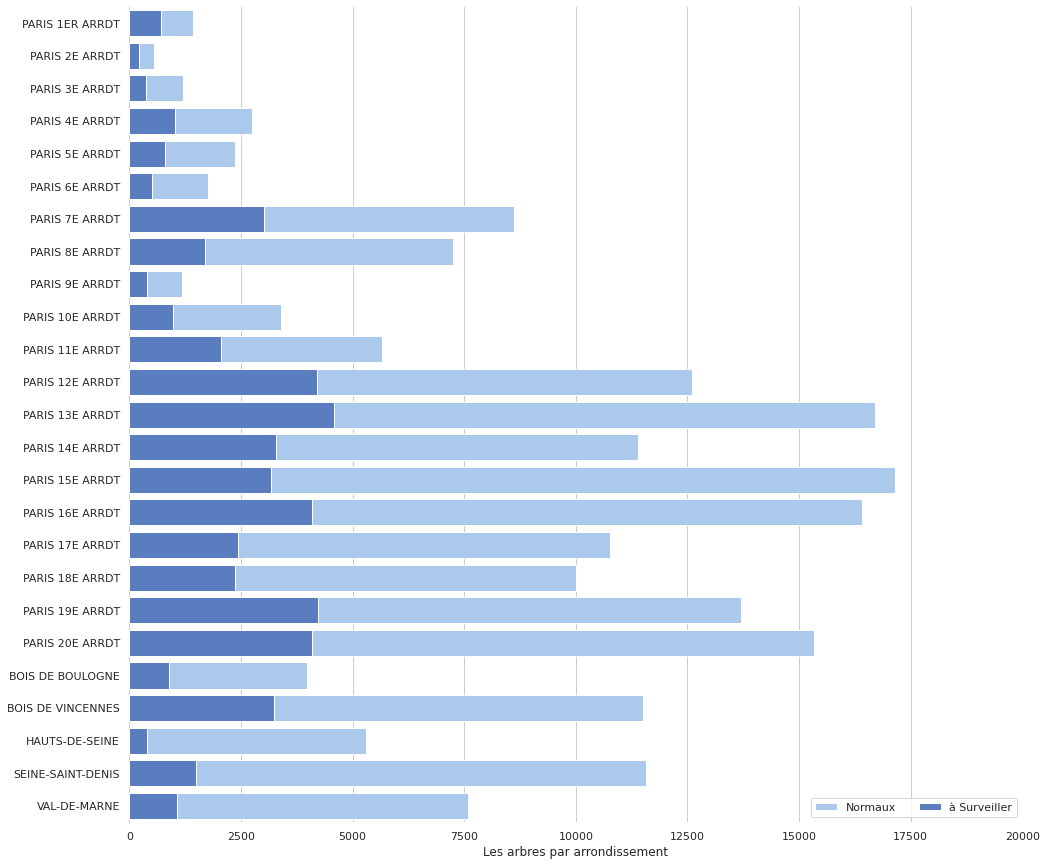

In [117]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(16, 15))

# Load the example car crash dataset
crashes = data_hist_chart

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(order=arr_list,x="total", y="arr", data=crashes,
            label="Normaux", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(order=arr_list,x="surveiller", y="arr", data=crashes,
            label="à Surveiller", color="b")

# Add a legend and informative axis label
ax.legend(ncol=3, loc="lower right", frameon=True)
ax.set(xlim=(0, 20000), ylabel="",
       xlabel="Les arbres par arrondissement")
sns_plot = sns.despine(left=True, bottom=True)
plt.show()

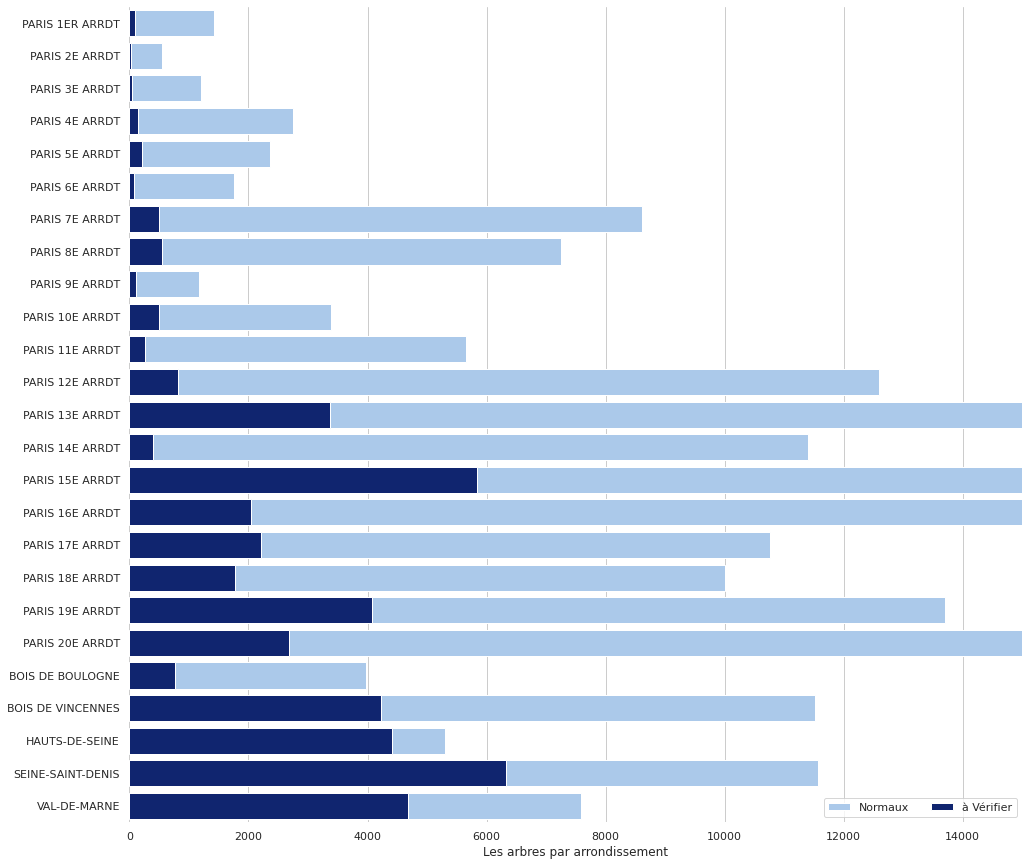

In [118]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(16, 15))

# Load the example car crash dataset
crashes = data_hist_chart
# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(order=arr_list,x="total", y="arr", data=crashes,
            label="Normaux", color="b")

# Plot the crashes where alcohol was involved
#sns.set_color_codes("muted")
#sns.barplot(order=arr_list,x="surveiller", y="arr", data=crashes,
#            label="à Surveiller", color="b")

sns.set_color_codes("dark")
sns.barplot(order=arr_list,x="verifier", y="arr", data=crashes,
            label="à Vérifier", color="b")


# Add a legend and informative axis label
ax.legend(ncol=3, loc="lower right", frameon=True)
ax.set(xlim=(0, 15000), ylabel="",
       xlabel="Les arbres par arrondissement")
sns_plot = sns.despine(left=True, bottom=True)
plt.show()

### Analyse du nombre d'arbre par arrondissement et par stade de développement.

In [119]:
qa9 = """SELECT actions.arrondissement as arr, 
                actions.age,
                COUNT(*) as total
                FROM actions
       GROUP BY actions.arrondissement, actions.age
"""

In [120]:
actions_hist_stadev = ps.sqldf(qa9, locals())

In [122]:
qa10 = """SELECT actions.arrondissement as arr, 
                actions.age,
                COUNT(soin) as surveiller
                FROM actions WHERE soin LIKE '%surveiller'
       GROUP BY actions.arrondissement, actions.age
"""

In [123]:
actions_hist_stadev_soin = ps.sqldf(qa10, locals())

In [125]:
qa11 = """SELECT actions_hist_stadev.arr as arr, 
                actions_hist_stadev.age,
                actions_hist_stadev.total,
                actions_hist_stadev_soin.surveiller 
                FROM actions_hist_stadev JOIN actions_hist_stadev_soin ON actions_hist_stadev.arr = actions_hist_stadev_soin.arr AND
                actions_hist_stadev.age = actions_hist_stadev_soin.age

"""


In [126]:

actions_hist_stadev_merge = ps.sqldf(qa11, locals())

In [127]:
actions_hist_stadev_merge

,arr,age,total,surveiller
0,BOIS DE BOULOGNE,A,1202,267
1,BOIS DE BOULOGNE,J,667,203
2,BOIS DE BOULOGNE,JA,1136,234
3,BOIS DE BOULOGNE,P,193,179
4,BOIS DE VINCENNES,A,2716,1003
...,...,...,...,...
119,VAL-DE-MARNE,A,1370,475
120,VAL-DE-MARNE,J,360,103
121,VAL-DE-MARNE,JA,646,150
122,VAL-DE-MARNE,M,153,108


In [128]:
data_hist__stdev_chart = actions_hist_stadev_merge.copy()

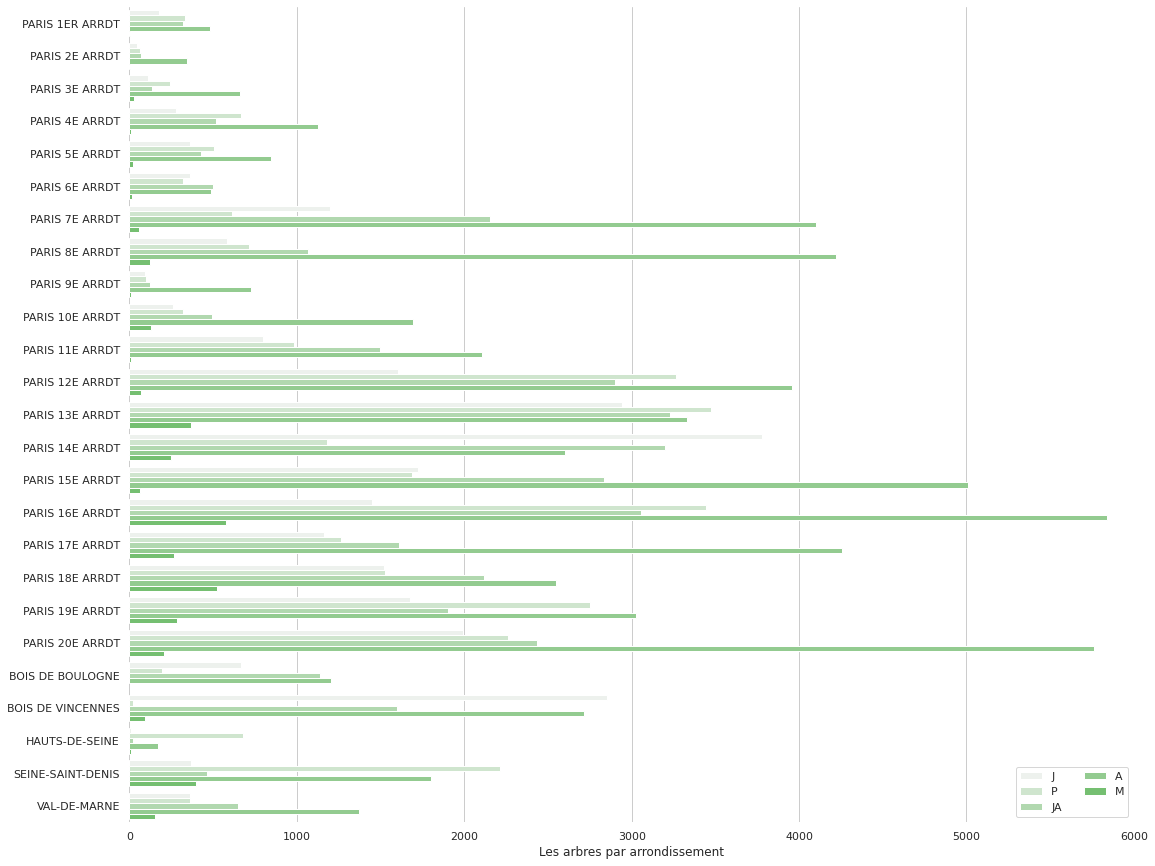

In [129]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(18, 15))

# Load the example car crash dataset
crashes = data_hist__stdev_chart
# Plot the total crashes
sns.set_color_codes("muted")
sns.barplot(order=arr_list, hue_order=['J','P','JA','A','M'],x="total", y="arr", hue="age", data=crashes,
             color="g")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 6000), ylabel="",
       xlabel="Les arbres par arrondissement")
sns_plot = sns.despine(left=True, bottom=True)



### Analyse des arbres les plus fréquents par arrondissement

In [130]:
freq_libel_arr = actions[['arrondissement', 'libelle_francais','nb_arbre_meme_libel_arr']].copy()

In [131]:
freq_libel_arr = freq_libel_arr[~freq_libel_arr.duplicated()].sort_values(by='arrondissement')

In [132]:
freq = pd.DataFrame()
for arr in list(freq_libel_arr['arrondissement'].unique()):
    freq =freq.append(freq_libel_arr.loc[freq_libel_arr['arrondissement'] == arr].sort_values(by='nb_arbre_meme_libel_arr').iloc[-5:])

In [133]:
freq_libel_arr.rename(columns={'libel':'libelle_francais'}).to_excel('data_freq_libel_arr.xlsx')

In [134]:
freq

,arrondissement,libelle_francais,nb_arbre_meme_libel_arr
51249,BOIS DE BOULOGNE,Tilleul,379
50372,BOIS DE BOULOGNE,Erable,390
54304,BOIS DE BOULOGNE,Platane,416
49406,BOIS DE BOULOGNE,Noisetier de Byzance,548
51780,BOIS DE BOULOGNE,Marronnier,1101
...,...,...,...
30432,VAL-DE-MARNE,Cerisier à fleurs,173
19019,VAL-DE-MARNE,Tilleul,198
19033,VAL-DE-MARNE,Peuplier,254
19526,VAL-DE-MARNE,Platane,294


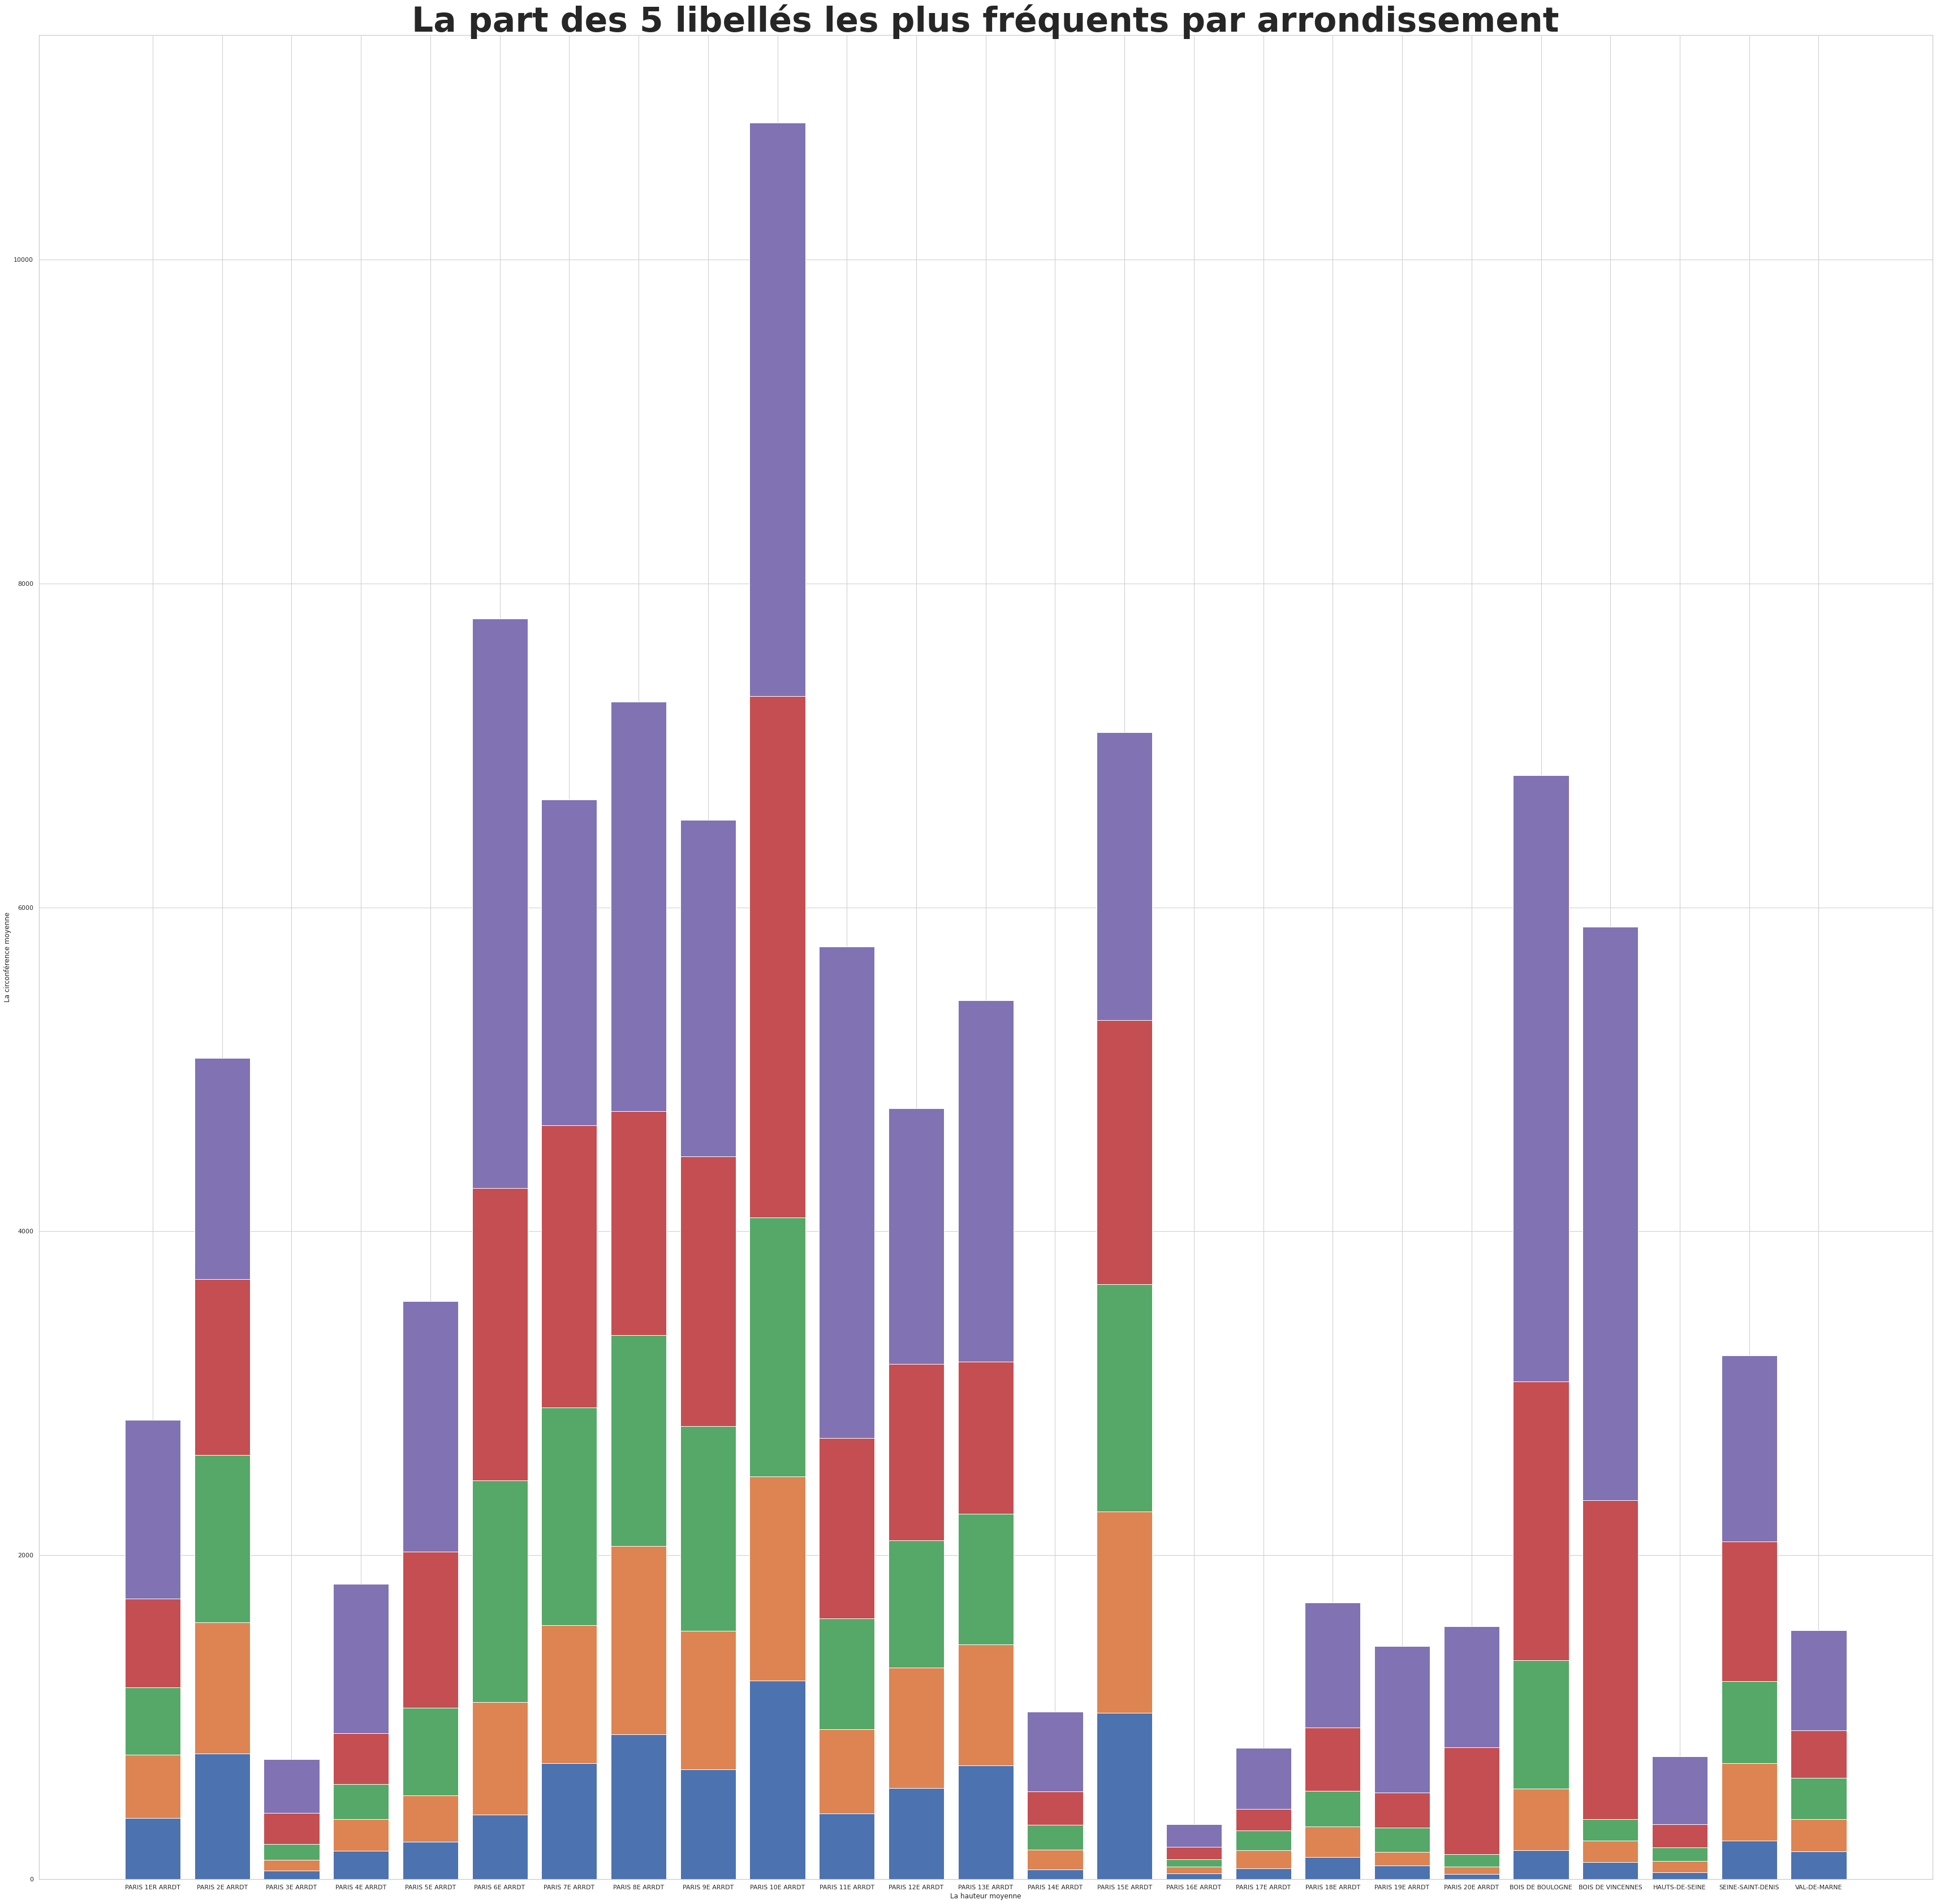

In [135]:
f, ax = plt.subplots(figsize=(60, 60))
A = np.array(list(freq['nb_arbre_meme_libel_arr'].iloc[0::5]))
B = np.array(list(freq['nb_arbre_meme_libel_arr'].iloc[1::5]))
C = np.array(list(freq['nb_arbre_meme_libel_arr'].iloc[2::5]))
D = np.array(list(freq['nb_arbre_meme_libel_arr'].iloc[3::5]))
E = np.array(list(freq['nb_arbre_meme_libel_arr'].iloc[4::5]))
Pos = range(25)
plt.bar(Pos, A)
plt.bar(Pos, B, bottom = A)
plt.bar(Pos, C, bottom = A + B)
plt.bar(Pos, D, bottom = A + B + C)
plt.bar(Pos, E, bottom = A + B + C + D)
plt.xticks(Pos, arr_list)
plt.title('La part des 5 libellés les plus fréquents par arrondissement', fontdict={'fontsize':60, 'fontweight':'bold'})
plt.ylabel('La circonférence moyenne')
plt.xlabel('La hauteur moyenne')
plt.show() 

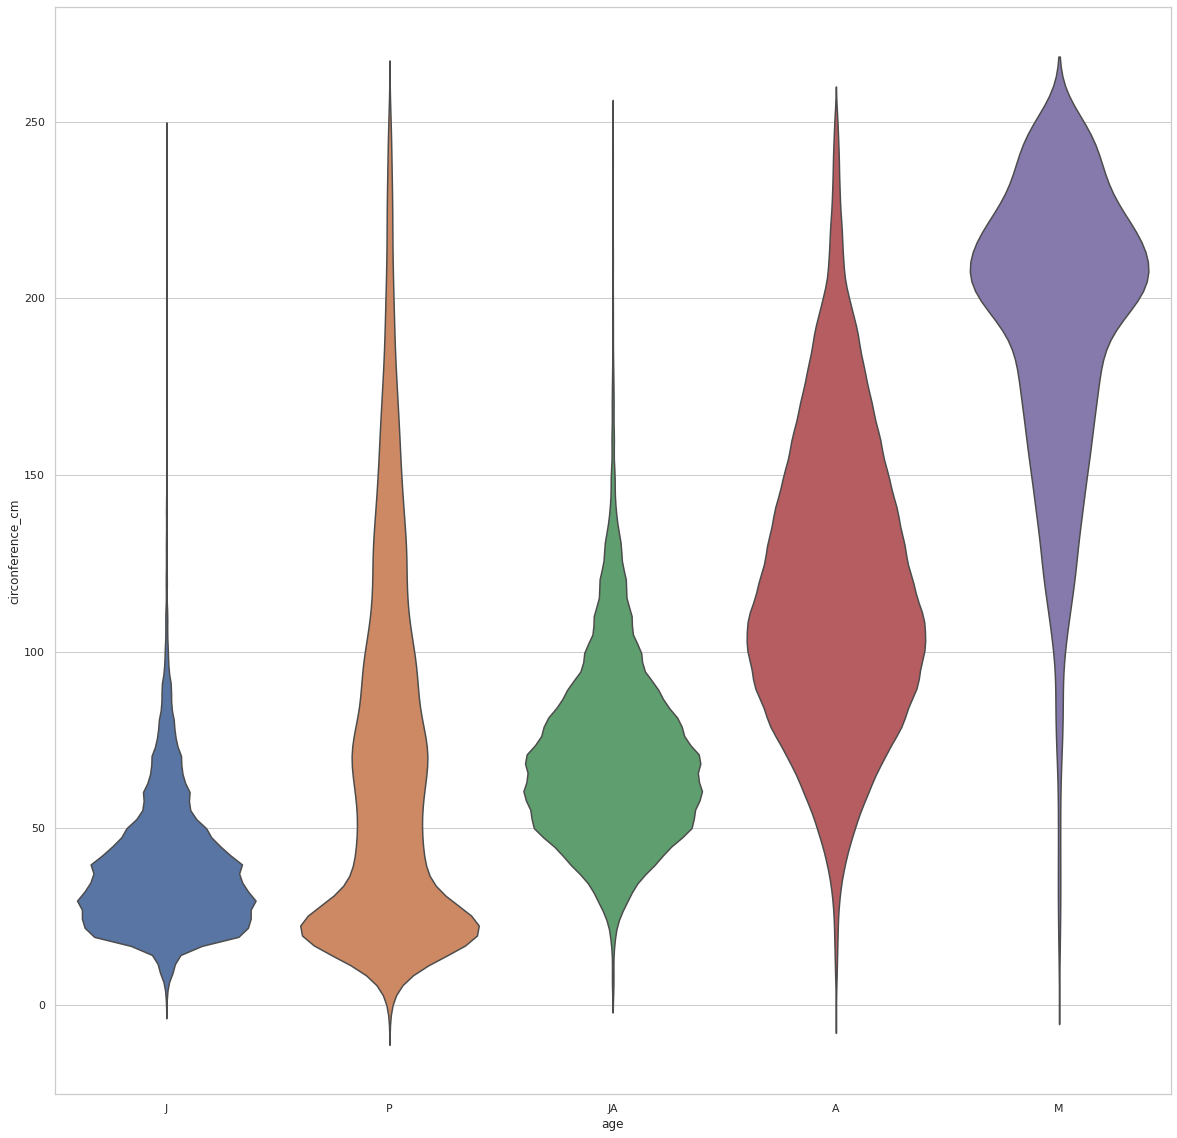

In [136]:
f = plt.figure(figsize=(20 , 20))
ax = sns.violinplot(order=['J','P','JA','A','M'],x="age", y="circonference_cm", data=actions, inner=None, scale='width')
f.savefig('draft/repartition_des_varietes_par_age_par_remarquable.png')

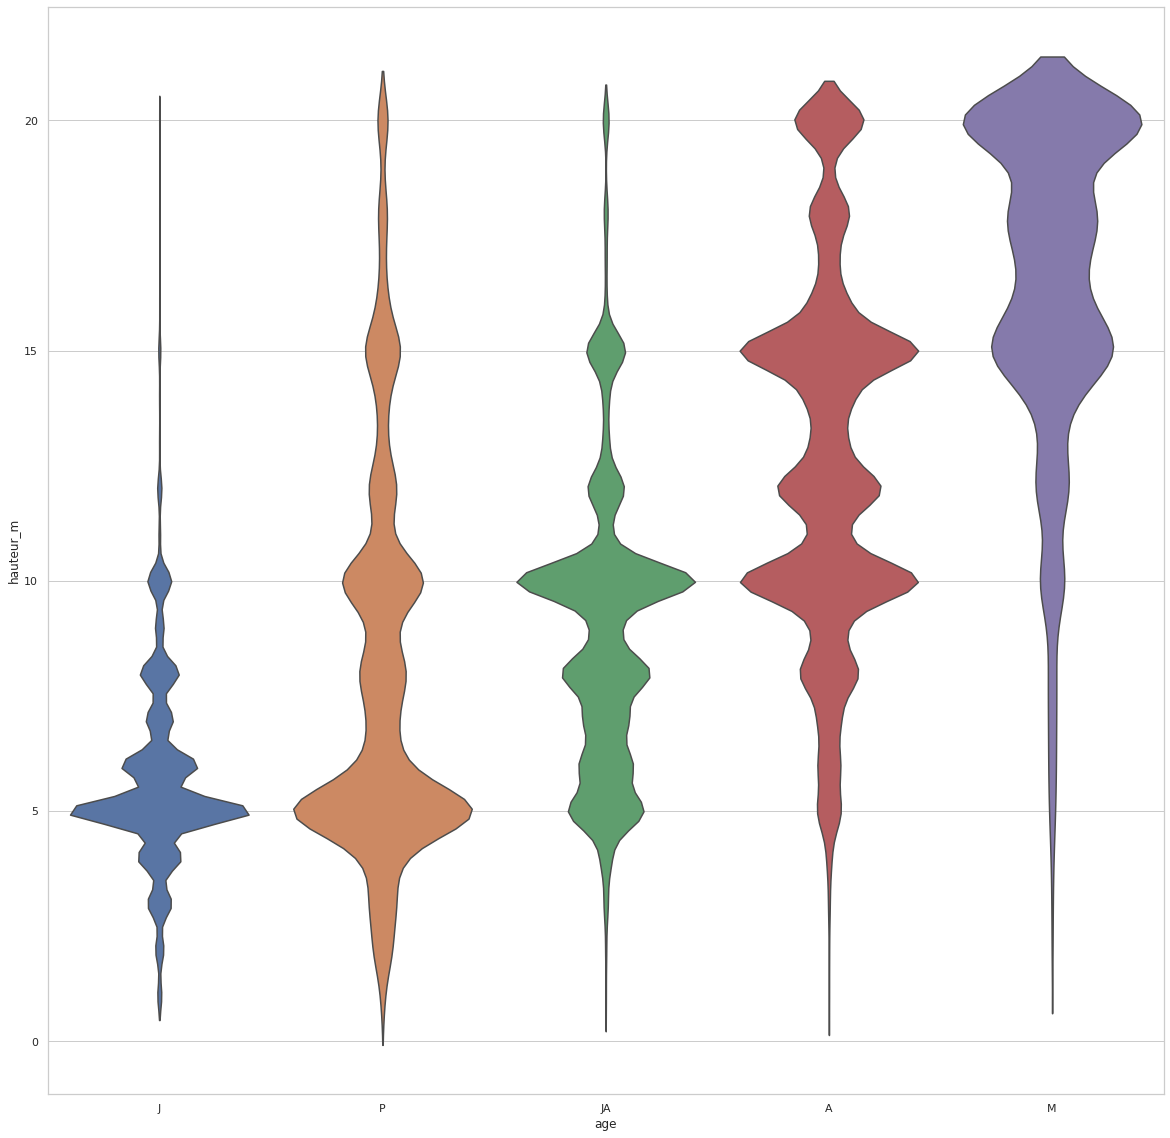

In [137]:
f = plt.figure(figsize=(20 , 20))
ax = sns.violinplot(order=['J','P','JA','A','M'],x="age", y="hauteur_m", data=actions, inner=None, scale='width')

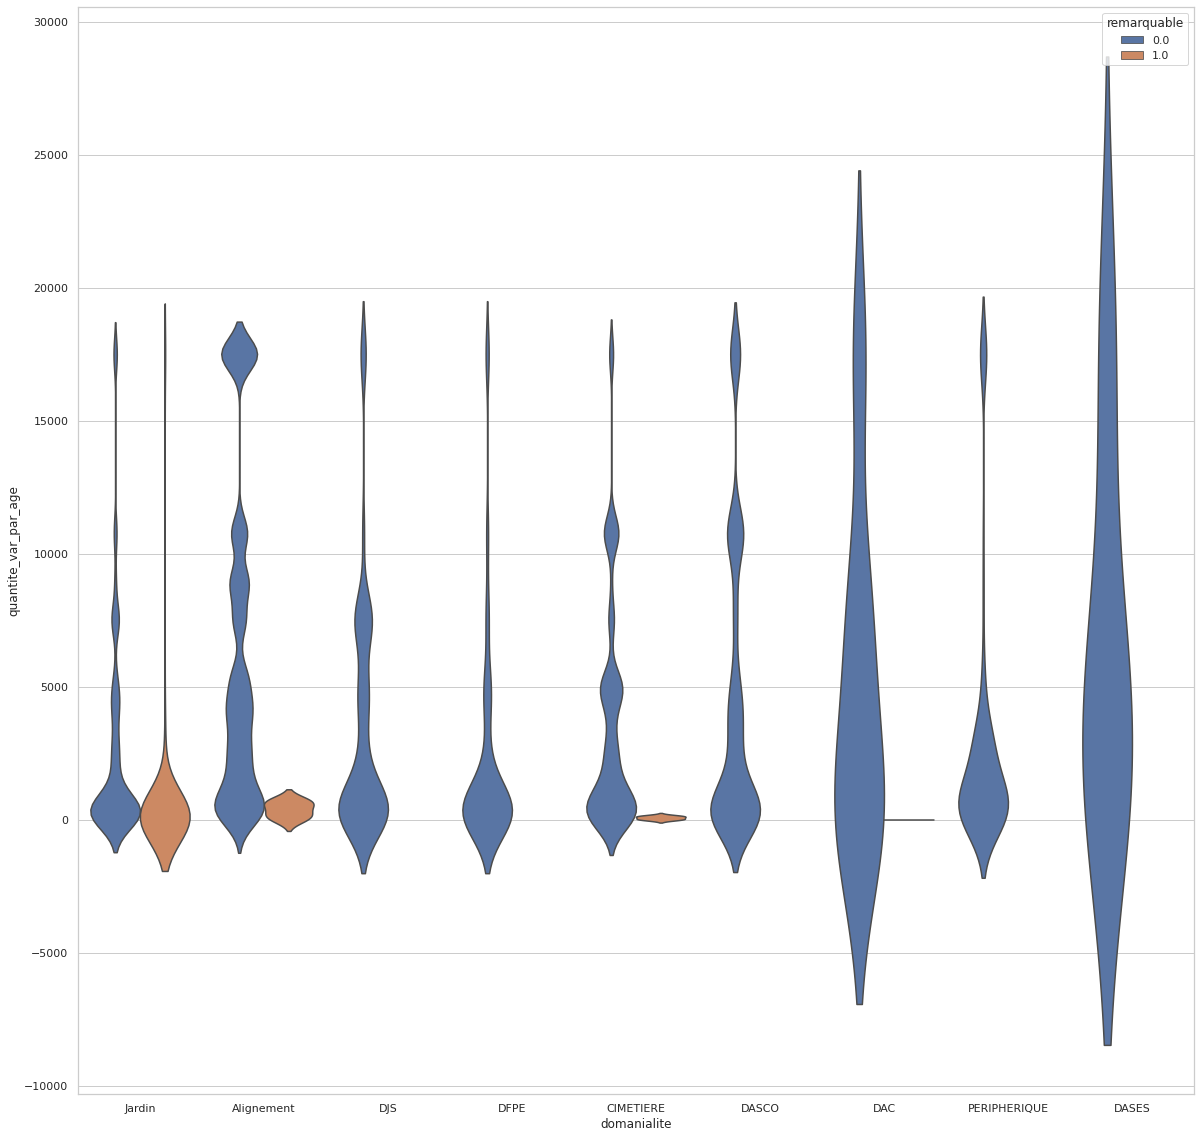

In [138]:
f = plt.figure(figsize=(20 , 20))
ax = sns.violinplot(x="domanialite",hue="remarquable", y="quantite_var_par_age", data=actions, inner=None, scale='width')

In [139]:
q12 = """SELECT actions.lieu as lieu, 
                actions.arrondissement,
                COUNT(*) as total
                FROM actions
       GROUP BY actions.lieu
"""

In [140]:
actions_hist_lieu = ps.sqldf(q12, locals())

In [141]:
actions_hist_lieu.loc[actions_hist_lieu['lieu']== 'JARDIN DE L AVENUE FOCH / 10 AVENUE FOCH']

,lieu,arrondissement,total
2908,JARDIN DE L AVENUE FOCH / 10 AVENUE FOCH,PARIS 16E ARRDT,601


In [142]:
q13 = """SELECT actions.lieu as lieu, 
                actions.arrondissement,
                COUNT(soin) as surveiller
                FROM actions WHERE soin LIKE '%surveiller'
       GROUP BY actions.lieu
"""

In [143]:
actions_hist_lieu_soin = ps.sqldf(q13, locals())

In [144]:
actions_hist_lieu_soin

,lieu,arrondissement,surveiller
0,28 BOULEVARD DE DOUAUMONT,PARIS 17E ARRDT,2
1,44 ENFANTS D'IZIEU,PARIS 13E ARRDT,1
2,48 BOULEVARD DE DOUAUMONT,PARIS 17E ARRDT,1
3,AFFRE (9),PARIS 18E ARRDT,1
4,ALAIN FOURNIER (5-7) TEP,PARIS 14E ARRDT,5
...,...,...,...
4216,VOSGES (12) MAT,PARIS 4E ARRDT,3
4217,VULPIAN (13) ELEM,PARIS 13E ARRDT,2
4218,WATTIGNIES (52) ELEM,PARIS 12E ARRDT,1
4219,WURTZ (16) ELEM,PARIS 13E ARRDT,2


In [145]:
q14 = """SELECT actions_hist_lieu_soin.lieu as lieu, 
                actions_hist_lieu.arrondissement,
                actions_hist_lieu.total,
                actions_hist_lieu_soin.surveiller 
                FROM actions_hist_lieu JOIN actions_hist_lieu_soin ON actions_hist_lieu.lieu = actions_hist_lieu_soin.lieu


"""


In [146]:

actions_hist_lieu_merge = ps.sqldf(q14, locals())

In [147]:
actions_hist_lieu_merge

,lieu,arrondissement,total,surveiller
0,28 BOULEVARD DE DOUAUMONT,PARIS 17E ARRDT,2,2
1,44 ENFANTS D'IZIEU,PARIS 13E ARRDT,3,1
2,48 BOULEVARD DE DOUAUMONT,PARIS 17E ARRDT,1,1
3,AFFRE (9),PARIS 18E ARRDT,2,1
4,ALAIN FOURNIER (5-7) TEP,PARIS 14E ARRDT,22,5
...,...,...,...,...
4216,VOSGES (12) MAT,PARIS 4E ARRDT,7,3
4217,VULPIAN (13) ELEM,PARIS 13E ARRDT,11,2
4218,WATTIGNIES (52) ELEM,PARIS 12E ARRDT,7,1
4219,WURTZ (16) ELEM,PARIS 13E ARRDT,13,2


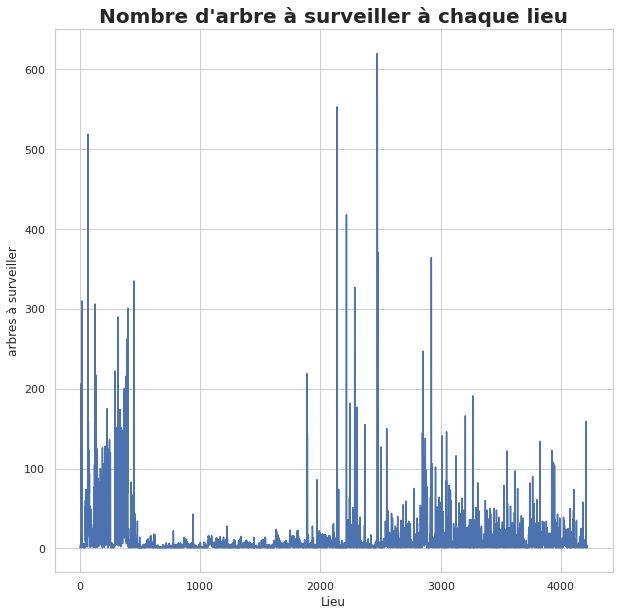

In [148]:
f = plt.figure(figsize=(10 , 10))
ax = actions_hist_lieu_merge['surveiller'].plot()
plt.title('Nombre d\'arbre à surveiller à chaque lieu', fontdict={'fontsize': 20, 'fontweight': 'bold'})
plt.xlabel('Lieu')
plt.ylabel('arbres à surveiller')
plt.savefig('draft/plot_surveiller_lieu.png')


In [149]:
chemin_note = pd.read_pickle('chemin.dat_0.95_0.05')

In [150]:
road_dict_df = dict()
for i in arr_list:
    road_dict_df.update({i:chemin_note['road'][i]})

In [151]:
road_df = pd.DataFrame.from_dict(road_dict_df, orient='index')

In [152]:
road_df.transpose().to_excel('chemin_par_arrondissement.xlsx')

In [153]:
actions_simple = actions.rename(columns={'lat':'geo_point_2d_a', 'lon':'geo_point_2d_b'})

In [154]:
action_df_simple = actions_simple[['type_emplacement', 'domanialite', 'arrondissement',
       'complement_addresse', 'lieu', 'id_emplacement', 'libelle_francais',
       'genre', 'espece', 'variete', 'circonference_cm', 'hauteur_m',
       'stade_developpement', 'remarquable', 'geo_point_2d_a',
       'geo_point_2d_b', 'soin']].copy()

In [155]:
action_df_simple.count()

type_emplacement       154067
domanialite            154067
arrondissement         154067
complement_addresse     29870
lieu                   154067
id_emplacement         154067
libelle_francais       154067
genre                  154067
espece                 154067
variete                154067
circonference_cm       154067
hauteur_m              154067
stade_developpement    154067
remarquable            122591
geo_point_2d_a         154067
geo_point_2d_b         154067
soin                   154067
dtype: int64

In [156]:
data.loc[((data["hauteur_m"] >= 21) | (data["hauteur_m"] <= 0)) \
                          | ((data["circonference_cm"] >= 255) | (data["circonference_cm"] <= 0))].count()

type_emplacement       46070
domanialite            46070
arrondissement         46070
complement_addresse    46070
numero                     0
lieu                   46070
id_emplacement         46070
libelle_francais       46070
genre                  46070
espece                 46070
variete                46070
circonference_cm       46070
hauteur_m              46070
stade_developpement    46070
remarquable            14448
geo_point_2d_a         46070
geo_point_2d_b         46070
sta_dev_num            46070
dtype: int64

In [157]:
data_new = data.loc[((data["hauteur_m"] >= 21) | (data["hauteur_m"] <= 0)) \
                          | ((data["circonference_cm"] >= 255) | (data["circonference_cm"] <= 0))].copy()

In [158]:
data_new['soin'] = 'à vérifier'

In [159]:
data_end = action_df_simple.append(data_new).copy()

In [160]:
data_end = data_end.drop(['sta_dev_num'], axis=1)

In [161]:
actions_simple['soin'].value_counts()

normal          102793
à surveiller     51274
Name: soin, dtype: int64

## Partie Algorithmie, Optimisation des trajets

À présent, nous allons tâcher de répondre à la problématique du meilleur trajet, qui est un problème similaire au problème du voyageur de commerce pour lequel nous souhaitons utiliser l'algorithme de [Christofides](https://fr.wikipedia.org/wiki/Algorithme_de_Christofides). Pour cela nous utiliserons un GPU en local, pour calculer les distances entre tous les lieux, et nous lancerons l'algorithme de recherche du plus court chemin entre tous les lieux soit $6921$ éléments distincts.

Nous devons suivre le schéma suivant pour construire l'algorithme de Christofides :



![Algorithme de Christofides](algorithme.png)

## Calcul du meilleur trajet

### Calcul des distances entre chaque lieu

Nous relevons 200137 points d'intérêts sur la table. Si nous descendons dans la structure hiérarchisé de nos données, nous comprenons qu'il s'agit geo_point_2d -> id_emplacement -> lieu + complement d'adresse -> lieu -> arrondissement. C'est à dire qu'un lieu regroupe des points d'intérêts sur la carte, des arbres dans notre cas.

Comme il s'agit de trouver une tournée véhiculée, entre $6921$ lieux uniques, contenant eux-mêmes un certain nombre d'arbres (chacun), et que ces lieux sont reliés entre eux par une distance pouvant se calculer d'après la latitude et la longitude, nous utiliserons une représentation en graphe (arrête et sommet) pour trouver le meilleurs chemins, en commençant par le calcul de la matrice des distances, puis du chemin de poids minimum…comme expliqué dans le diagramme ci-dessus.

1. Nous calculerons la quantité d'arbres d'un lieu par la fonction d'aggrégeage "aggfunc" ci-dessous. Nous disposerons le résultat dans une colonne portant le nom de aire, car c'est une donnée quantitative que nous souhaitons représenter sous la forme de cercle avec plus ou moins de surface.

![Algorithme de Christofides](christofides_plan.png)

In [69]:
df = data[['arrondissement', 'lieu', 'geo_point_2d_a', 'geo_point_2d_b', 'genre']].copy()

In [70]:
lieu_aire = pd.DataFrame(df.pivot_table(index=['lieu'], aggfunc='size'), columns=['aire'])

In [71]:
x = lieu_aire.reset_index()

**Nous éliminons ainsi les lieux doublons**, notons que les bulles de circonférences sont en rapport avec le nombre de ligne (et donc d'arbre) disparaissant dans cette opération.

In [72]:
df = df.drop_duplicates(subset='lieu', ignore_index=True)

In [73]:
set_1 = set(list(lieu_aire.index))

In [74]:
set_2 = set(list(df['lieu']))

In [75]:
set_2 == set_1

True

In [76]:
q7 = """SELECT  df.lieu as lieu,
                df.arrondissement as arrond,
                df.geo_point_2d_a as lat,
                df.geo_point_2d_b as lon,
                x.aire as aire
                FROM df INNER JOIN x ON df.lieu == x.lieu ORDER BY lieu"""

In [77]:
df_graph = ps.sqldf(q7, locals())

In [78]:
df_graph

,lieu,arrond,lat,lon,aire
0,28 BOULEVARD DE DOUAUMONT,PARIS 17E ARRDT,48.895329,2.306259,2
1,44 ENFANTS D'IZIEU,PARIS 13E ARRDT,48.821548,2.355661,3
2,48 BOULEVARD DE DOUAUMONT,PARIS 17E ARRDT,48.894733,2.305240,1
3,5 RUE CLEMENT MYIONNET = 22 SEBASTIEN MERCIER,PARIS 15E ARRDT,48.844000,2.278437,3
4,AFFRE (9),PARIS 18E ARRDT,48.885685,2.355373,2
...,...,...,...,...,...
6916,VOSGES (12) MAT,PARIS 4E ARRDT,48.855192,2.366584,7
6917,VULPIAN (13) ELEM,PARIS 13E ARRDT,48.831415,2.346642,11
6918,WATTIGNIES (52) ELEM,PARIS 12E ARRDT,48.835420,2.397004,8
6919,WURTZ (16) ELEM,PARIS 13E ARRDT,48.827259,2.343882,13


Nous exportons notre tableau trier par ordre alphabétique de lieu pour l'utiliser sur notre gpu et pour que nous réalisions le calcul de la matrice des distances entre les lieux.

2. Nous calculerons la matrices des distances entre chaque lieu sur un gpu (le code est fourni en annexe), et ce sera donc une matrice de (6921 x 6921). Une distance est donnée par la relation $\sqrt{((x_1 - x_0)*111)^2 + ((y_1 - y_0)*80)^2} ,\forall x \in latitude, \forall  y\in longitude$ en France, pour la distance en $km$. Le script de calcul de cette matrice est réalisé dans l'IDE PyCharm avec la bibliothèque PyCuda et une carte NVIDIA, localement. L'écriture du code en C ne se prête hélas pas tellement, visuellement parlant, au Notebook de Jupyter.

En sortie nous traitons notre matrice pour la retrouver dans une dataframe avec nos indexes et colonnes en nom de lieu. Comme les calculs ont été réalisés dans des "numpy arrays" les colonnes n'ont pas été nommées. Mais nous avons effectuer les calculs sur un échantillon des données avec notre cpu, puis nous importerons le fichier de résultats de 600Mo dans une DataFrame pour les comparer et voir que nous trouvons le même résultat sur un échantillon.

In [79]:
distances_cpu = pd.DataFrame(df_graph, index=df_graph['lieu'].unique(), columns=df_graph['lieu'].unique())

In [80]:
for it, row in enumerate(distances_cpu.iloc[:5,:5].columns):
    for it, col in enumerate(distances_cpu.iloc[:5,:5].columns):
        distances_cpu[col].loc[row] = math.sqrt(((df_graph['lat'].loc[df_graph['lieu'] == col].values - df_graph['lat'].loc[df_graph['lieu'] == row].values)*111)**2\
+ ((df_graph['lon'].loc[df_graph['lieu'] == col].values - df_graph['lon'].loc[df_graph['lieu'] == row].values)*80)**2)

distances_cpu.iloc[:5,:5]

,28 BOULEVARD DE DOUAUMONT,44 ENFANTS D'IZIEU,48 BOULEVARD DE DOUAUMONT,5 RUE CLEMENT MYIONNET = 22 SEBASTIEN MERCIER,AFFRE (9)
28 BOULEVARD DE DOUAUMONT,0.000000,9.093349,0.104967,6.116801,4.072280
44 ENFANTS D'IZIEU,9.093349,0.000000,9.069851,6.661610,7.119260
48 BOULEVARD DE DOUAUMONT,0.104967,9.069851,0.000000,6.025796,4.134473
5 RUE CLEMENT MYIONNET = 22 SEBASTIEN MERCIER,6.116801,6.661610,6.025796,0.000000,7.700141
AFFRE (9),4.072280,7.119260,4.134473,7.700141,0.000000


## Code GPU de calcul de la matrice des distances 

Compte-tenu qu'il est nécessaire d'utiliser Anaconda, cela contreviendrait à la consigne qui stipule que l'exercice doit intégrer un environnement virtuel propre. Mais le code est présenté pour preuve :

Ici nous importons les résultats des calculs fait à partir de notre gpu local, sur la matrice heuristique des distances entre lieux. Ce fichier fait 600 Méga Octets.
Nous voyons que les échantillons ci-dessus, et ci-dessous ont des résultats semblables. Comme le chargement du fichier prend trop de temps, nous avons pris le soin de produire un échantillon de 25 lieux, et c'est lui que nous chargeons.

Nous comparons le résultat avec le tableau ci-dessous pour comprendre que tout s'est bien passé sur notre gpu et que nous pouvons travailler avec nos données.

Nous sauvegardons un échantillon de notre matrice pour pouvoir effectuer le programme sur 25 lieux :

## Problème du voyageur de commerce, algorithme de Christofides

Nous considérons un graphe G(V,E) dont les poids respectent l'égalité triangulaire $d_{ij}+d_{jk}\le d_{ik}$.

La première étape de l'écriture de cet algorithme est l'écriture un arbre couvrant le poids minimum.
Nous vous le présentons ci-dessous :

Ainsi, nous avons présenté les données de la ville de Paris, nous avons effectué une analyse univariée sur les éléments chiffrés, à la suite de quoi, nous avons calculé la matrice des distances entre les lieux, en ayant éliminé les doublons. Pour la présentation future du graphe, nous avons rajouté le nombre d'arbres par lieu dans la colonne aire, et une couleur distincte par arrondissement. Enfin nous avons résolu algorithmiquement le chemin de poids minimum pour n'importe quel point de départ. Par contre l'algorithme que nous avons développé à partir du schéma proposé par Christofides étant de complexité $O(x) = x^2$, il nous semble bien ambitieux pour 6921 lieux, et donc aussi pour le calculer dans ce projet dans des délais raisonnables, nous utiliserons un GPU.

### Optimisation des trajets

In [81]:
import christofides

christofides.christofides()

le chemin de poids nominal était de :  8.271345687893035
Pour l'arrondissement PARIS 1ER ARRDT : 

Nombre de kilomètre : 5
Chemin de départ : ['AVENUE VICTORIA', 'RUE DES HALLES', 'RUE SAINT DENIS', 'PLACE DU CHATELET', 'RUE DE LA FERRONNERIE', 'RUE DES INNOCENTS', 'RUE DE LA REYNIE', 'PLACE JOACHIM DU BELLAY', 'RUE DE LA COSSONNERIE', 'RUE DE LA GRANDE TRUANDERIE', 'JARDINIERE DE LA RUE MAUCONSEIL / 31 RUE MAUCON MAUCONSEIL', 'RUE DE TURBIGO', 'RUE COQUILLIERE', 'RUE JEAN JACQUES ROUSSEAU', 'PLACE DES DEUX ECUS', 'JARDINS DES HALLES', 'SQUARE MICHEL CALDAGUES / 1V PLACE DU LOUVRE', 'PLACE DU LOUVRE', 'QUAI DE LA MEGISSERIE', 'QUAI DU LOUVRE', 'QUAI DE L HORLOGE', 'PLACE DAUPHINE', 'QUAI DES ORFEVRES', 'SQUARE DU VERT GALANT / 4W PLACE DU PONT NEUF', 'BOULEVARD DU PALAIS', 'PORT DU LOUVRE', 'PORT DES TUILERIES', 'QUAI FRANCOIS MITTERRAND', 'QUAI DES TUILERIES', 'PLACE DU MARCHE SAINT HONORE', 'PLACE MAURICE BARRES', 'BOULEVARD DE LA MADELEINE', 'PLACE ANDRE MALRAUX']

Nombre de kilomèt

Pour l'arrondissement PARIS 8E ARRDT : 

Nombre de kilomètre : 11
Chemin de départ : ['AVENUE CESAR CAIRE', 'SQUARE MARCEL PAGNOL / 12 RUE DE LABORDE', 'BOULEVARD HAUSSMANN', 'PLACE SAINT AUGUSTIN', 'PLACE DU GUATEMALA', 'AVENUE PERCIER', 'AVENUE RUYSDAEL', 'AVENUE DE MESSINE', 'PARC MONCEAU', 'BOULEVARD DE COURCELLES', 'RUE BERNOUILLI', 'AVENUE VELASQUEZ', 'RUE DE BERNE', 'BOULEVARD DES BATIGNOLLES', 'MOSCOU (7) MAT', 'PLACE DE DUBLIN', 'RUE TRONCHET', 'SURENE (18) ELEM (18)', 'PLACE DE LA MADELEINE', 'RUE ROYALE', 'PLACE DES SAUSSAIES', 'AVENUE DE MARIGNY', 'AVENUE FRANKLIN D ROOSEVELT', 'AVENUE MATIGNON', 'ROND POINT CHAMPS ELYSEES', 'AVENUE DES CHAMPS ELYSEES', 'JARDINS DES CHAMPS ELYSEES / GRAND PALAIS', 'AVENUE DE SELVES', 'AVENUE DUTUIT', 'COURS LA REINE', 'AVENUE MONTAIGNE', 'SQUARE JEAN PERRIN / 2 AVENUE FRANKLIN D ROOSEVELT', 'PLACE DE LA REINE ASTRID', 'JARDIN DES ABORDS DU PASSAGE SOUTERRAIN PLACE DE L ALMA', 'PLACE DE L ALMA', 'COURS ALBERT 1ER', 'AVENUE GEORGE V', 'AVENUE

le chemin de poids nominal était de :  33.48781922315819
Pour l'arrondissement PARIS 13E ARRDT : 

Nombre de kilomètre : 32
Chemin de départ : ["44 ENFANTS D'IZIEU", 'RUE KEUFER', 'RUE MAX JACOB', 'JARDIN DU MONUMENT AUX MERES FRANCAISES', 'RUE DU PROFESSEUR LOUIS RENAULT', 'CRECHE (12-14) MAX JACOB', 'RUE DE LA POTERNE DES PEUPLIERS', 'MAX JACOB (12-14)', 'RUE DE SAINTE HELENE', 'AVENUE CAFFIERI', 'ECOLE POLYVALENTE / 8 RUE KUSS', 'PC13 - JARDIN DE LA RUE DE LA POTERNE DES PEUPLIERS / 62 RUE DAMESME', 'ECOLE ELEMENTAIRE / 8 RUE KUSS', 'ALBIN HALLER 5', 'JARDIN CHARLES TRENET / 31 RUE BRILLAT SAVARIN', 'RUE ALBIN HALLER', 'PLACE DE RUNGIS', 'RUE DE RUNGIS', 'RUE DES ORCHIDEES', 'RUE DES IRIS', 'RUE CHARBONNEL', 'RUE DE L AMIRAL MOUCHEZ', 'WURTZ (16) ELEM', 'TOLBIAC (235)', 'ECOLE MATERNELLE / 16 RUE WURTZ', 'GLACIERE (101)', 'ECOLE ELEMENTAIRE / 100 RUE DE LA GLACIERE', 'ECOLE MATERNELLE / 100 RUE DE LA GLACIERE', 'RUE DE LA GLACIERE', 'VULPIAN (13) ELEM', 'RECULETTES (21-23) HALTE GAR

le chemin de poids nominal était de :  35.451227234252926
Pour l'arrondissement PARIS 15E ARRDT : 

Nombre de kilomètre : 29
Chemin de départ : ['ALLEE DES CYGNES', 'BOULEVARD DE GRENELLE', 'CENTRE SPORTIF FEDERATION / 16 RUE DE LA FEDERATION', 'ECOLE MATERNELLE / 18 RUE FEDERATION', 'RUE EMERIAU', 'ECOLE MATERNELLE / 16 RUE EMERIAU', 'PLACE SAINT CHARLES', 'ROUELLE (25) ELEM', 'RUE GINOUX', 'PLACE CHARLES MICHELS', 'RUE PAUL HERVIEU', 'ECOLE MATERNELLE / 35 AVENUE EMILE ZOLA', 'AVENUE EMILE ZOLA', 'RUE BALARD', 'PROMENADE DU QUAI ANDRE CITROEN / 13 QUAI  ANDRE CITROEN', 'QUAI ANDRE CITROEN', 'RUE DU PIC DE BARRETTE', 'ESPLANADE MAX GUEDJ', 'ECOLE MATERNELLE / 72 RUE GUTENBERG', 'CIMETIERE DE GRENELLE / AVENUE CENTRALE / DIV 3', 'JONGKIND (3) MAT', 'RUE JONGKIND', 'FELIX FAURE (146) ELEM', 'ECOLE MATERNELLE / 95 RUE BALARD', 'PLACE BALARD', 'RUE LEBLANC', 'PARC ANDRE CITROEN', 'RUE SAINT CHARLES', 'BOULEVARD GENERAL MARTIAL VALIN', 'TALUS N°09-06', 'PLACE DES MARTYRS DE LA RESISTANCE',

le chemin de poids nominal était de :  29.033985825504104
Pour l'arrondissement PARIS 17E ARRDT : 

Nombre de kilomètre : 24
Chemin de départ : ['AMPERE (18) ELEM', 'ECOLE MATERNELLE / 18 RUE AMPERE', 'ECOLE MATERNELLE / 3 RUE GUSTAVE DORE', 'PLACE DE WAGRAM', 'CRECHE COLLECTIVE / 84 BOULEVARD PEREIRE', 'BOULEVARD BERTHIER', 'PROMENADE BERNARD LAFAY C3', 'BRUNETIERE (16)', 'PROMENADE BERNARD LAFAY C2', 'SQUARE ANDRE ULMANN', 'REIMS (38-40) ELEM', 'CENTRE SPORTIF REIMS / 34 BOULEVARD DE REIMS', 'BOULEVARD DE REIMS', 'AVENUE EMILE ET ARMAND MASSARD', 'SQUARE SAINTE ODILE / 1 BOULEVARD DE LA SOMME', 'RUE DE COURCELLES', 'PROMENADE BERNARD LAFAY PR B2', 'CENTRE SPORTIF COURCELLES / 209 RUE DE COURCELLES', 'RUE CURNONSKY', 'PROMENADE BERNARD LAFAY PR C1', 'TALUS N°18-04', 'TALUS N°18-06', 'PLACE LOUIS BERNIER', 'BOULEVARD DU FORT DE VAUX', 'CRECHE COLLECTIVE / 30 RUE CHRISTINE DE PISAN', 'ECOLE MATERNELLE / 24 RUE CHRISTINE DE PISAN', 'ECOLE MATERNELLE / 8 RUE DES TAPISSERIES', 'RUE DE SAUS

le chemin de poids nominal était de :  31.672811435321428
Pour l'arrondissement PARIS 19E ARRDT : 

Nombre de kilomètre : 28
Chemin de départ : ['ALLEE DARIUS MILHAUD', 'GOUBET (4) ELEM', 'RUE PETIT', 'RUE GOUBET', 'ECOLE ELEMENTAIRE / 160 AVENUE JEAN JAURES', 'JARDINIERE ALLEE DARIUS MILHAUD', 'RUE GEORGES THILL', 'CRECHE COLLECTIVE / 168 AVENUE JEAN JAURES', 'SOLIDARITE (3)', 'RUE DAVID D ANGERS', 'RUE DU GENERAL BRUNET', 'COMPANS (106) ELEM A', 'PLACE RHIN ET DANUBE', 'RUE FRANCIS PONGE', 'AVENUE AMBROISE RENDU', 'CRECHE COLLECTIVE / 21 RUE DE LA PREVOYANCE', 'RUE DES MARCHAIS', 'AVENUE DE LA PORTE BRUNET', 'RUE DE MOUZAIA', 'SQUARE DE LA BUTTE DU CHAPEAU ROUGE / 11 BOULEVARD D ALGERIE', 'RUE DU PRE SAINT GERVAIS', 'BOULEVARD D ALGERIE', 'JARDIN D ENFANT OPAC / 17 RUE DE L ORME', 'RUE DES BOIS', 'RUE SIGMUND FREUD', 'CENTRE SPORTIF DE LA PORTE CHAUMONT / 22 AVENUE DE LA PORTE CHAUMONT', 'SQUARE DE LA MARSEILLAISE / 21 AVENUE DE LA PORTE CHAUMONT', 'ECOLE MATERNELLE / 5 RUE NOYER DUR

le chemin de poids nominal était de :  34.55596391073725
Pour l'arrondissement HAUTS-DE-SEINE : 

Nombre de kilomètre : 5
Chemin de départ : ['CIMETIERE DE BAGNEUX / AVENUE DE FONTENAY / DIV 24', 'CIMETIERE DE BAGNEUX / AVENUE DES COPALMES / DIV 24', 'CIMETIERE DE BAGNEUX / AVENUE DES ORMES PUMILA / DIV 23', 'CIMETIERE DE BAGNEUX / AVENUE DES COPALMES / DIV 32', 'CIMETIERE DE BAGNEUX / AVENUE DES ORMES PUMILA / DIV 24', 'CIMETIERE DE BAGNEUX / AVENUE DES ERABLES POURPRES / DIV 16', 'CIMETIERE DE BAGNEUX / AVENUE DES COPALMES / DIV 30', 'CIMETIERE DE BAGNEUX / AVENUE DES COPALMES / DIV 31', 'CIMETIERE DE BAGNEUX / AVENUE DES COPALMES / DIV 22', 'CIMETIERE DE BAGNEUX / AVENUE DES FRENES MONOPHYLLES / DIV 29', 'CIMETIERE DE BAGNEUX / AVENUE DES SOPHORAS / DIV 30', 'CIMETIERE DE BAGNEUX / AVENUE DES SOPHORAS / DIV 29', 'CIMETIERE DE BAGNEUX / AVENUE DES FRENES MONOPHYLLES / DIV 37', 'CIMETIERE DE BAGNEUX / AVENUE DES COPALMES / DIV 28', 'CIMETIERE DE BAGNEUX / AVENUE DES ERABLES POURPRES /

le chemin de poids nominal était de :  27.93856982566847
Pour l'arrondissement VAL-DE-MARNE : 

Nombre de kilomètre : 22
Chemin de départ : ["CENTRE SPORTIF D'ORLY / VOIE DES SAULES 94310 ORLY", 'CIMETIERE DE THIAIS / AVENUE K / DIV 126', 'CIMETIERE DE THIAIS / AVENUE K / DIV 124', 'CIMETIERE DE THIAIS / AVENUE K / DIV 118', 'CIMETIERE DE THIAIS / AVENUE K / DIV 116', 'CIMETIERE DE THIAIS / AVENUE I / DIV 102', 'CIMETIERE DE THIAIS / AVENUE M / DIV 86', 'CIMETIERE DE THIAIS / AVENUE M / DIV 94', 'CIMETIERE DE THIAIS / AVENUE I / DIV 103', 'CIMETIERE DE THIAIS / AVENUE I / DIV 104', 'CIMETIERE DE THIAIS / AVENUE G / DIV 74', 'CIMETIERE DE THIAIS / AVENUE I / DIV 106', 'CIMETIERE DE THIAIS / AVENUE D / DIV 50', 'CIMETIERE DE THIAIS / AVENUE D / DIV 42', 'CIMETIERE DE THIAIS / AVENUE DU POURTOUR EST / DIV 34', 'CIMETIERE DE THIAIS / AVENUE C / DIV 42', 'CIMETIERE DE THIAIS / AVENUE DU POURTOUR EST / DIV F34', 'CIMETIERE DE THIAIS / AVENUE B / DIV 34', 'CIMETIERE DE THIAIS / AVENUE DU POUR

## Carte des positions

In [64]:
 data_map = pd.read_excel('data/new_data_end_0.95_0.05.xlsx')

In [65]:
poi_list = ['orange', 'blue', 'red']
poi_icon_list = ['heart', 'ok-sign', 'question-sign']
poi_dict = dict()
for it, val in enumerate(data_map['soin'].unique()):
    poi_dict.update({val: poi_list[it]})
poi_icon_dict = dict()
for it, val in enumerate(data_map['soin'].unique()):
    poi_icon_dict.update({val: poi_icon_list[it]})
poi_icon_dict

{'à surveiller': 'heart', 'normal': 'ok-sign', 'à vérifier': 'question-sign'}

In [66]:
data_map['poi'] = data_map['soin'].map(poi_dict)
data_map['poi_icon'] = data_map['soin'].map(poi_icon_dict)

In [67]:
def valeur(colonne, it, arr):
    return data_map[colonne].loc[data_map['arrondissement']==arr].reset_index().iloc[i].values[1]

In [68]:
"""
m = folium.Map(location=[48.857722, 2.321031], zoom_start=12, tiles="Stamen Terrain")
value = int()
for j, arr in enumerate(list(['PARIS 2E ARRDT'])):#data_map['arrondissement'].unique())):
    #data_valeur = data_map['geo_point_2d_a'].loc[data_map['arrondissement']==arr]
    print('carte de ', arr)
    for i in range(len(data_map['geo_point_2d_a'].loc[data_map['arrondissement']==arr])):
        #print(len(data_map['geo_point_2d_a'].loc[data_map['arrondissement']==arr]))
        folium.Marker(
            location=[valeur('geo_point_2d_a', i, arr),
                      valeur('geo_point_2d_b', i, arr)],
                      
            popup=str(valeur('genre', i, arr)) + ', ' + 
            str(valeur('espece', i, arr)) + ', ' + str(
                valeur('variete', i, arr)) + ', ' +
                  str(valeur('libelle_francais', i, arr)) 
            + ', haut. : ' + str(float(valeur('hauteur_m', i, arr))) +
                  'm, circ. : ' + str(float(valeur('circonference_cm', i, arr))) + 'cm, action à prendre : ' +
                  valeur('soin', i, arr),
            icon=folium.Icon(icon=valeur('poi_icon', i, arr), color=valeur('poi', i, arr)),
        ).add_to(m)
    m.save("data/map/index_"+'_'.join(arr.split(' '))+ ".html")
"""

carte de  PARIS 2E ARRDT


# 3) Synthèse de mon analyse

Nous avons réalisé cette algorithme sur nos données

![Algorithme](analyse.png)

Nous proposons à nos clients de prendre soin de cette quantités d'arbres :

![Arbres à surveiller par arrondissement](img/arbre_a_surveiller_par_arrondissement_q_h_0.95_0.05.png)

Et de revoir la saisie des données de cette quantité d'arbres : 

![Arbres à vérifier par arrondissement](img/arbre_a_verifier_par_arrondissement_q_h_0.95_0.05.png)


Nous lui faisons prendre conscience des différents nombres d'arbres à surveiller dans chaque lieu 

![Arbres à surveiller par lieu](img/plot_surveiller_lieu_q_h_0.95_0.05.png)

Nous lui donnons des informations sur les arbres remarquables :

![Arbres remarquables par domanialite](img/remarquable_par_domanialite_0.95_0.05.png)

![Arbres remarquables par arrondissement](img/remarquable_par_arrondissement_0.95_0.05.png)

Nous lui montrons la répartitions des 5 plus hautes fréquences de variétés dans chaque arrondissement :

![5 plus hautes fréquences de variétés par arrondissement](img/part_des_5_libels_freq_par_arrondissement_0.95_0.05.png)


Nous lui montrons la répartitions des circonférences par arrondissement :

![Arbre à surveiller par arrondissement](img/data_arbre_a_surveiller_par_arrondissement_q_h_0.95_0.05.png)

![Arbre normal et à surveiller par age](img/arbre_norm_surv_par_age_0.95_0.05.png)

Nous lui montrons la répartition par arrondissement et par stade de développement :

![Nombre d'arbre par arrondissement et par stade de dev](img/nombre_arbre_par_arrondissement_par_stade_de_dev_q_h_0.95_0.05.png)

Nous lui montrons la répartition des hauteurs par stade de développement :

![Répartition des hauteurs et par stade de dev](img/repartition_des_hauteur_par_age_0.95_0.05.png)

Nous lui montrons la répartition des circonférences par stade de développement :

![Répartition des circonférences et par stade de dev](img/repartition_des_circonference_par_age_0.95_0.05.png)

Nous lui montrons la répartition des variétés par stade de développement et remarquabilité, pour qu'il comprenne que les arbres remarquables sont des petits groupes de variétés, et que les arbres de stade mûr sont aussi des petits groupes de variétés :

![Répartition des variétés, par stade de dev et remarquabilité](img/repartition_des_varietes_par_age_par_remarquable_0.95_0.05.png)


Ensuite nous lui indiquons quartier par quartier les points d'intérêts à surveiller car les arbres sont au-dessus ou au-dessous des normes. Et aussi des données à saisir de nouveau ou à compléter par le terme à vérifier.

[lien vers la carte de PARIS 1ER ARRDT](data/map/index_PARIS_1ER_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 2E ARRDT](data/map/index_PARIS_2E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 3E ARRDT](data/map/index_PARIS_3E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 4E ARRDT](data/map/index_PARIS_4E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 5E ARRDT](data/map/index_PARIS_5E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 6E ARRDT](data/map/index_PARIS_6E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 7E ARRDT](data/map/index_PARIS_7E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 8E ARRDT](data/map/index_PARIS_8E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 9E ARRDT](data/map/index_PARIS_9E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 10E ARRDT](data/map/index_PARIS_10E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 11E ARRDT](data/map/index_PARIS_11E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 12E ARRDT](data/map/index_PARIS_12E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 13E ARRDT](data/map/index_PARIS_13E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 14E ARRDT](data/map/index_PARIS_14E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 15E ARRDT](data/map/index_PARIS_15E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 16E ARRDT](data/map/index_PARIS_16E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 17E ARRDT](data/map/index_PARIS_17E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 18E ARRDT](data/map/index_PARIS_18E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 19E ARRDT](data/map/index_PARIS_19E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 20E ARRDT](data/map/index_PARIS_20E_ARRDT_0.95_0.05.html)

[lien vers la carte de BOIS DE BOULOGNE](data/map/index_BOIS_DE_BOULOGNE_0.95_0.05.html)

[lien vers la carte de BOIS DE VINCENNES](data/map/index_BOIS_DE_VINCENNES_0.95_0.05.html)

[lien vers la carte de HAUTS-DE-SEINE](data/map/index_HAUTS-DE-SEINE_0.95_0.05.html)

[lien vers la carte de SEINE-SAINT-DENIS](data/map/index_SEINE-SAINT-DENIS_0.95_0.05.html)

[lien vers la carte de VAL-DE-MARNE](data/map/index_VAL-DE-MARNE_0.95_0.05.html)



Pour faire le tour des points d'intérêts le plus vite possible, nous avons calculé un chemin parmi les plus court par l'algorithme de Christofides que nous avons écrit en Python et dont la sortie est un tableur excel dont voici un extrait : (Chaque colonne indique le chemin à suivre pour faire au plus vite dans un arrondissement)

In [162]:
pd.read_excel('data/chemin_par_arrondissement_0.95_0.05.xlsx').drop(['Unnamed: 0'],axis=1).head()

,PARIS 1ER ARRDT,PARIS 2E ARRDT,PARIS 3E ARRDT,PARIS 4E ARRDT,PARIS 5E ARRDT,PARIS 6E ARRDT,PARIS 7E ARRDT,PARIS 8E ARRDT,PARIS 9E ARRDT,PARIS 10E ARRDT,...,PARIS 16E ARRDT,PARIS 17E ARRDT,PARIS 18E ARRDT,PARIS 19E ARRDT,PARIS 20E ARRDT,BOIS DE BOULOGNE,BOIS DE VINCENNES,HAUTS-DE-SEINE,SEINE-SAINT-DENIS,VAL-DE-MARNE
0,AVENUE VICTORIA,BEAUREGARD (5) ELEM,BOULEVARD BEAUMARCHAIS,AVE MARIA (22) ELEM,ARBALETE (41) ELEM,BOULEVARD DU MONTPARNASSE,AVENUE BARBEY D AUREVILLY,AVENUE CESAR CAIRE,AVENUE TRUDAINE,AQUEDUC (39) ELEM,...,AVENUE BUGEAUD,28 BOULEVARD DE DOUAUMONT,AFFRE (9),ALLEE CESARIA EVORA / RUE CESARIA EVORA,ALQUIER DEBROUSSE (12) MAT,ALLEE DE LA REINE MARGUERITE,ALLEE DES LAPINS,CIMETIERE DE BAGNEUX / AVENUE DE BAGNEUX / DIV...,CIMETIERE DE LA CHAPELLE / AVENUE CENTRALE / D...,CENTRE SPORTIF D'ORLY / VOIE DES SAULES 94310 ...
1,JARDINIERES ANGLE RUE DE RIVOLI - RUE DES HALL...,BOULEVARD DE BONNE NOUVELLE,SQUARE LEOPOLD ACHILLE / 5 RUE DU PARC ROYAL,ECOLE MATERNELLE / 4 RUE FAUCONNIER,LYONNAIS (22) MAT,LITTRE (6) MAT,AVENUE JOSEPH BOUVARD,SQUARE MARCEL PAGNOL / 12 RUE DE LABORDE,TURGOT (15) ELEM,AQUEDUC (39) MAT,...,BELLES FEUILLES (3) ELEM,TALUS N°19-50,RUE JEAN FRANCOIS LEPINE,RUE GASTON TESSIER,RUE SERPOLLET,BOULEVARD RICHARD WALLACE,ALLEE ROYALE,CIMETIERE DE BAGNEUX / AVENUE DE BAGNEUX / DIV...,CIMETIERE DE LA CHAPELLE / AVENUE CENTRALE / D...,CIMETIERE DE THIAIS / AVENUE O / DIV 122
2,RUE SAINT DENIS,SQUARE JACQUES BIDAULT / 18 RUE DE LA LUNE,ECOLE MATERNELLE / 52 RUE DE TURENNE,TEP DES JARDINS SAINT PAUL / 9 RUE CHARLEMAGNE,LYONNAIS (7),LITTRE (2 ET 4),AVENUE ELISEE RECLUS,BOULEVARD HAUSSMANN,PLACE D ANVERS,LOUIS BLANC (49) MAT,...,RUE MERIMEE,BOULEVARD DE DOUAUMONT,SQUARE ALAIN BASHUNG,SQUARE DE LA RUE CURIAL / 85 RUE CURIAL,CENTRE SPORTIF LOUIS LUMIERE / 30 RUE LOUIS LU...,BOULEVARD MAURICE BARRES,ROUTE DE BOURBON,CIMETIERE DE BAGNEUX / AVENUE DES POMMIERS A F...,CIMETIERE DE LA CHAPELLE / AVENUE DU MIDI / DIV 8,CIMETIERE DE THIAIS / AVENUE I / DIV 106
3,PLACE DU CHATELET,RUE NOTRE DAME DE BONNE NOUVELLE,ECOLE ELEMENTAIRE / 54 RUE DE TURENNE,SQUARE MARIE TRINTIGNANT,RUE DES LYONNAIS,LITTRE (6) ELEM,AVENUE EMILE POUVILLON,PLACE SAINT AUGUSTIN,SQUARE D'ANVERS / 13 PLACE D ANVERS,RUE LOUIS BLANC,...,RUE DES BELLES FEUILLES,48 BOULEVARD DE DOUAUMONT,RUE DE JESSAINT,JARDINIERE RUE HENRI VERNEUIL / 12 RUE GASTON ...,TEP DAVOUT / 134 BOULEVARD DAVOUT,BOULEVARD DU COMMANDANT CHARCOT,ROUTE DE LA DEMI LUNE,CIMETIERE DE BAGNEUX / AVENUE DES MARAICHERS /...,CIMETIERE DE LA CHAPELLE / AVENUE DU MIDI / DIV 6,CIMETIERE DE THIAIS / AVENUE J / DIV 114
4,RUE DES HALLES,RUE DE LA LUNE,SQUARE GEORGES CAIN / 8 RUE PAYENNE,RUE DE L AVE MARIA,RUE DE BAZEILLES,PLACE DU DIX HUIT JUIN 1940,GENERAL CAMOU (1) ELEM,PLACE DU GUATEMALA,CRECHE COLLECTIVE / 18 RUE DE LA TOUR D AUVERGNE,LOUIS BLANC (49B) ELEM,...,LONGCHAMP (130) ELEM,PLACE LOUIS BERNIER,VOIE AU/18,RUE HENRI VERNEUIL,RUE LOUIS LUMIERE,BOULEVARD MAILLOT,ROUTE DE LA FALUERE,CIMETIERE DE BAGNEUX / AVENUE DE L'AULNAIE / D...,CIMETIERE DE LA CHAPELLE / AVENUE DU MIDI / DI...,CIMETIERE DE THIAIS / AVENUE O / DIV 97


Nous lui indiquons la quantité d'arbres à surveiller dans chaque lieu, chaque arrondissement :

In [163]:
pd.read_excel('data/quant_surveiller_lieu_q_h_0.95_0.05.xlsx').drop(['Unnamed: 0'],axis=1).head()

,lieu,arrondissement,total,surveiller
0,28 BOULEVARD DE DOUAUMONT,PARIS 17E ARRDT,2,2
1,44 ENFANTS D'IZIEU,PARIS 13E ARRDT,3,1
2,48 BOULEVARD DE DOUAUMONT,PARIS 17E ARRDT,1,1
3,AFFRE (9),PARIS 18E ARRDT,2,1
4,ALAIN FOURNIER (5-7) TEP,PARIS 14E ARRDT,22,5


In [164]:
pd.read_excel('data/quant_surveiller_arrondissement_q_h_0.95_0.05.xlsx').drop(['Unnamed: 0'],axis=1).head()

,arr,total,surveiller
0,BOIS DE BOULOGNE,3209,883
1,BOIS DE VINCENNES,7286,3244
2,HAUTS-DE-SEINE,890,399
3,PARIS 10E ARRDT,2896,984
4,PARIS 11E ARRDT,5393,2060


Nous lui indiquons les fréquences des variétés par arrondissement :

In [165]:
pd.read_excel('data/data_freq_libel_arr.xlsx').drop(['Unnamed: 0'],axis=1).head()

,arrondissement,libelle_francais,nb_arbre_meme_libel_arr
0,BOIS DE BOULOGNE,Orme de Sibérie,18
1,BOIS DE BOULOGNE,Pterocarya,4
2,BOIS DE BOULOGNE,Erable,390
3,BOIS DE BOULOGNE,Noyer,1
4,BOIS DE BOULOGNE,Cerisier à fleurs,6


Et nous lui rendons sa base de données, en prenant le soin de lui ajouter une colonne indiquant si l'arbre est normal, à surveiller ou si la donnée est à vérifier :

In [166]:
pd.read_excel('data/new_data_end_0.95_0.05.xlsx').drop(['Unnamed: 0', 'id'],axis=1).columns

Index(['type_emplacement', 'domanialite', 'arrondissement',
       'complement_addresse', 'lieu', 'id_emplacement', 'libelle_francais',
       'genre', 'espece', 'variete', 'circonference_cm', 'hauteur_m',
       'stade_developpement', 'remarquable', 'geo_point_2d_a',
       'geo_point_2d_b', 'soin', 'numero'],
      dtype='object')